# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input data
'data/processed/df_model.csv'

## Stages
1. train/test split
2. test data transformations (differencing and log) and perform residuals analyses
3. Auto-ARIMA parameter search
4. TimeSeriesSplit CV parameter search on out-of-sample performance
5. Residuals analyses on best models
6. SARIMA model selection

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import time
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot

from src.preprocessing import GasPreprocessor
from src.model_evaluation import evaluate_models_tscv, in_sample_resid_analysis, out_of_sample_resid_analysis, summarize_model_assumptions
print('GasPreprocessor imported successfully!')
print('model_evaluation functions imported successfully!')

GasPreprocessor imported successfully!
model_evaluation functions imported successfully!


# Load the data

In [3]:
# load cleaned data

df = pd.read_csv(
    '../data/processed/df_model.csv',
    index_col=0,
    parse_dates=True,
    dtype={'value': float, 'value_unc': float, 'qcflag': str}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 1746 records


value  value_unc qcflag
1991-01-04  1719.845       2.71    ...
1991-01-11  1736.940       2.71    ...
1991-01-18  1728.335       2.71    ...
1991-01-25  1716.080       2.71    ...
1991-02-01  1727.430       2.71    ...

In [4]:
df.tail()

value  value_unc qcflag
2024-11-25  1970.8250      0.575    ...
2024-12-06  1959.4500      0.575    ...
2024-12-17  1923.0025      0.575    ...
2024-12-24  1952.3800      0.575    ...
2024-12-31  1977.4450      0.575    .S.

## Resample full dataset

The full dataset will be resampled to weekly ('W') ahead of train/test split and subsequent preprocessing because:
1.  The mode of the observations after aggregation (see notebook 2_ch4_eda) is 52 observations/year
2.  Previous efforts to resample the train and test sets separtely, as part of the GasPreprocessor class functionality, has led to problems with the gap between the last train set value and the first test set value.  I have experienced gaps that are either too great (2 week gap) or are non-existant such that the last train datapoint date is the same as the first test set datapoint date, which is data leakage.

In [5]:
df_float = df[['value', 'value_unc']].resample('W').mean()
df_obj = df[['qcflag']].resample('W').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

df_resamp = pd.concat([df_float, df_obj], axis=1)

In [6]:
df_resamp.head()

value  value_unc qcflag
1991-01-06  1719.845       2.71    ...
1991-01-13  1736.940       2.71    ...
1991-01-20  1728.335       2.71    ...
1991-01-27  1716.080       2.71    ...
1991-02-03  1727.430       2.71    ...

In [7]:
# compare indexes to note change in datetime indexes and frequency

print('df first 5 indexes:')
print(df.index[:5])
print('\ndf_resamp firt 5 indexes:')
print(df_resamp.index[:5])

df first 5 indexes:
DatetimeIndex(['1991-01-04', '1991-01-11', '1991-01-18', '1991-01-25',
               '1991-02-01'],
              dtype='datetime64[ns]', freq=None)

df_resamp firt 5 indexes:
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')


In [8]:
# inspect resampled data for NaNs
print('Number of NaN values in each df_samp feature')
print('value: ', df_resamp['value'].isna().sum())
print('value_unc: ', df_resamp['value_unc'].isna().sum())
print('qcflag: ', df_resamp['qcflag'].isna().sum())

Number of NaN values in each df_samp feature
value:  47
value_unc:  47
qcflag:  47


## Rename 'value' to 'CH4' for GasPreprocessor class

In [9]:
df_resamp = df_resamp.rename(columns={'value': 'CH4'})

In [10]:
df_resamp.head()

CH4  value_unc qcflag
1991-01-06  1719.845       2.71    ...
1991-01-13  1736.940       2.71    ...
1991-01-20  1728.335       2.71    ...
1991-01-27  1716.080       2.71    ...
1991-02-03  1727.430       2.71    ...

# Train/test split

## Split the data and inspect

In [11]:
# split by calendar year

# ensure that the index is a DatetimeIndex and sorted
df_resamp_sort_ind = df_resamp.sort_index()
assert isinstance(df_resamp_sort_ind.index, pd.DatetimeIndex) 

train = df_resamp_sort_ind[df_resamp_sort_ind.index.year < 2024]
test = df_resamp_sort_ind[df_resamp_sort_ind.index.year >= 2024]

In [12]:
print(f'Train data: {train.shape[0]} data points, from {train.index.min()} to {train.index.max()}')
print(f'Test data: {test.shape[0]} data points, from {test.index.min()} to {test.index.max()}')

Train data: 1722 data points, from 1991-01-06 00:00:00 to 2023-12-31 00:00:00
Test data: 53 data points, from 2024-01-07 00:00:00 to 2025-01-05 00:00:00


In [13]:
# check the data frequency

print(f'Train data frequency: {train.index.freq}')
print(f'Test data frequency: {test.index.freq}')

Train data frequency: <Week: weekday=6>
Test data frequency: <Week: weekday=6>


<Week: weekday=6> == W-SUN

## Inspect the gap between train and test sets

In [14]:
# Check the last training point vs first test point

print('Last training date:', train.index[-1])
print('First test date:', test.index[0])
print('\nGap between train end and test start:', test.index[0] - train.index[-1])

Last training date: 2023-12-31 00:00:00
First test date: 2024-01-07 00:00:00

Gap between train end and test start: 7 days 00:00:00


## Visually confirm the data split

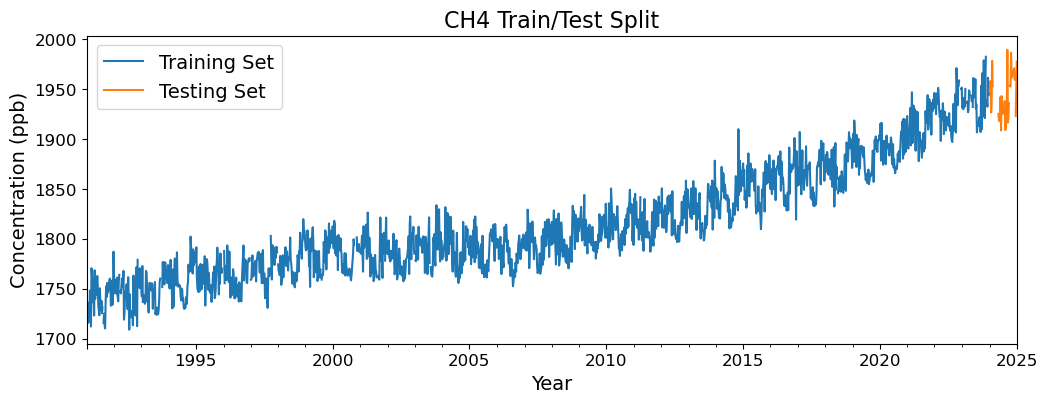

In [15]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
train['CH4'].plot(ax=ax, label='Training Set')
test['CH4'].plot(ax=ax, label='Testing Set')

ax.set_title('CH4 Train/Test Split', fontsize=16)
ax.set_ylabel('Concentration (ppb)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=14)
plt.show()

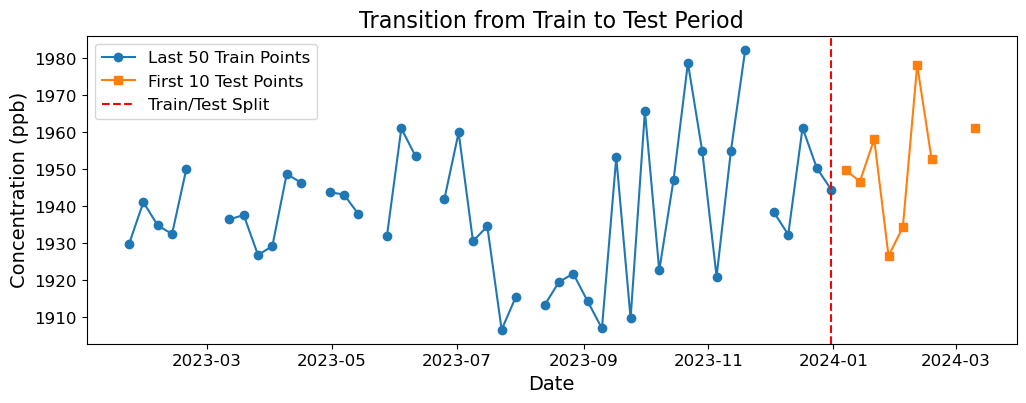

In [16]:
# Plot the transition from train to test

plt.figure(figsize=(12,4))
plt.plot(train['CH4'].index[-50:], train['CH4'].values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(test['CH4'].index[:10], test['CH4'].values[:10],
         label='First 10 Test Points', marker='s')
plt.axvline(x=train['CH4'].index[-1], color='red', linestyle='--', 
            label='Train/Test Split')

plt.title('Transition from Train to Test Period', fontsize=16)
plt.ylabel('Concentration (ppb)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper left',fontsize=12)
plt.show()

# Proprocessing and EDA of train set


[INFO] Fitting preprocessing for CH4
[INFO] Starting fit() for CH4 | Resample freq = None (using existing index)
Raw data: 1722 points, 37 NaNs
Trimmed data: 1722 points, 37 NaNs
Data range after trimming: 1991-01-06 00:00:00 to 2023-12-31 00:00:00
After resampling: 1722 points, 37 NaNs
[INFO] Found 30 potential outliers using robust STL residuals.
After outlier removal: 1722 points, 67 NaNs
After smoothing: 1722 points, 0 NaNs
After interpolation: 1722 points, 0 NaNs


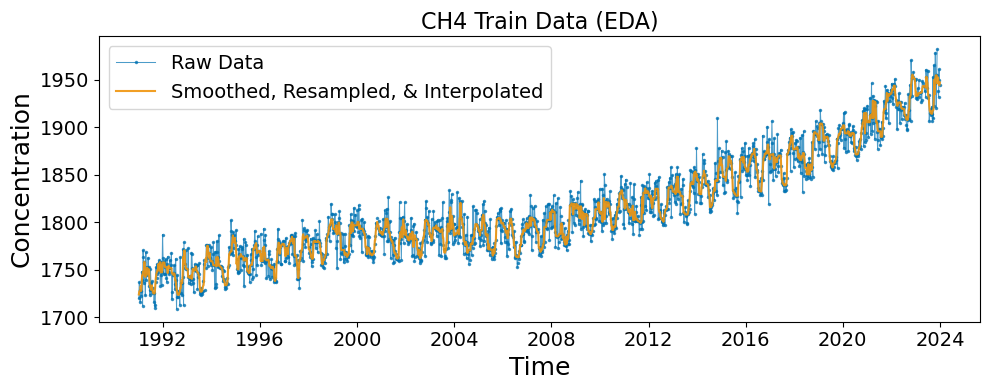

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.3406
ADF p-value 0.9196
ADF critical values: {'1%': -3.4342002032721437, '5%': -2.8632406484200064, '10%': -2.5676753800009053}

KPSS statistic 5.8061
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


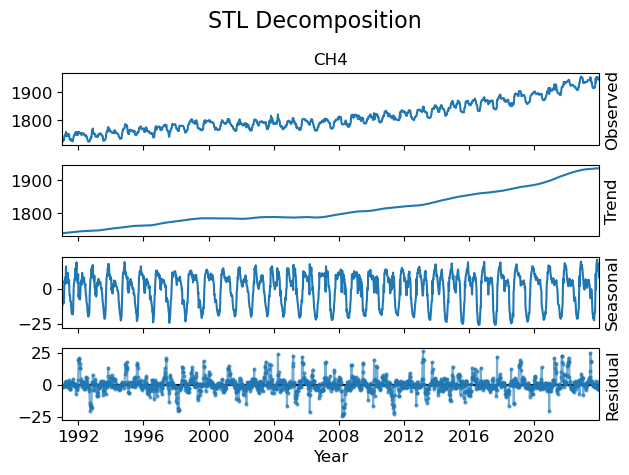

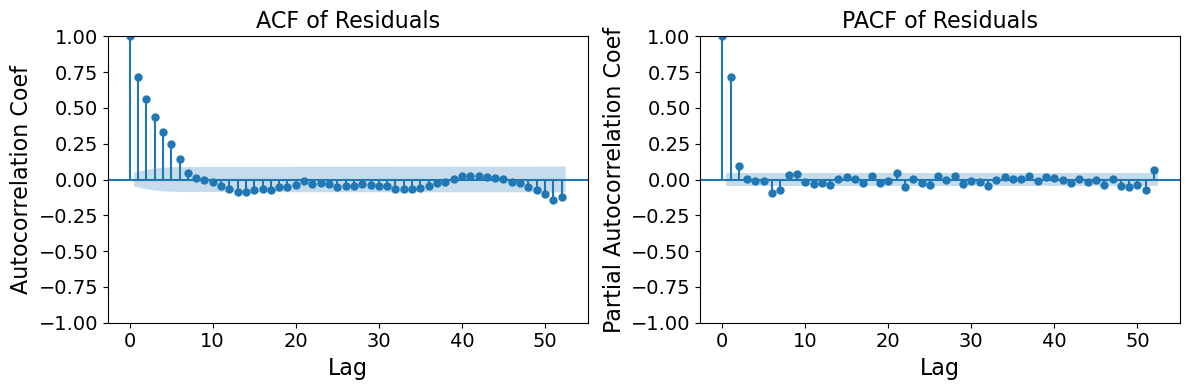


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.4836
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.7617
No heteroscedasticity detected (White test)
Adjusting test set dates to be contiguous with train set
[INFO] Dropping overlapping test point at 2023-12-31 00:00:00 (train end = 2023-12-31 00:00:00)


In [17]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

preprocessor = GasPreprocessor(
    gas_name='CH4', 
    iqr_factor=3.0,
    seasonal_period=52,
    do_eda=True
)

train_preprocessed = preprocessor.fit_transform(
    train[['CH4']], 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
test_preprocessed = preprocessor.transform(test[['CH4']])

In [18]:
train_preprocessed.tail()

2023-12-03    1952.61250
2023-12-10    1947.39875
2023-12-17    1944.51750
2023-12-24    1944.51750
2023-12-31    1947.39875
Freq: W-SUN, Name: CH4, dtype: float64

In [19]:
test_preprocessed.head()

2024-01-07    1946.68750
2024-01-14    1948.25750
2024-01-21    1949.82750
2024-01-28    1949.77875
2024-02-04    1952.87000
Freq: W-SUN, Name: CH4, dtype: float64

In [20]:
# check length of each data series

print(f'length of train_preprocessed: {len(train_preprocessed)}')
print(f'Number of NaNs in train_preprocessed: {train_preprocessed.isna().sum()}')
print(f'length of test_preprocessed: {len(test_preprocessed)}')
print(f'Number of NaNs in test_preprocessed: {test_preprocessed.isna().sum()}')

length of train_preprocessed: 1722
Number of NaNs in train_preprocessed: 0
length of test_preprocessed: 52
Number of NaNs in test_preprocessed: 0


## Determine if seasonal cycles are multiplicative

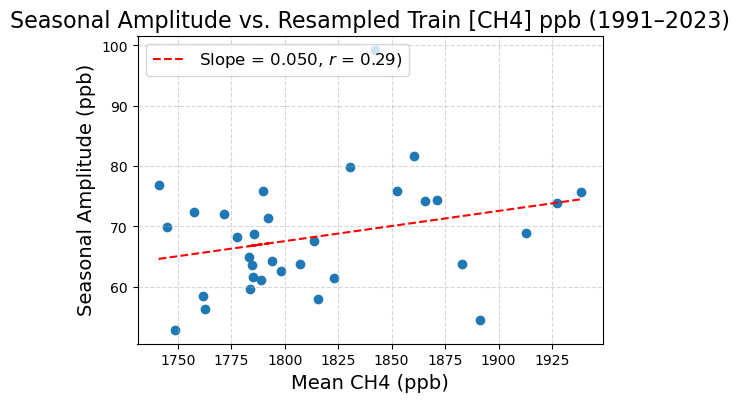

In [21]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the resampled CH4 train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

train_copy = train[['CH4']].copy()
train_copy['year'] = train_copy.index.year

# Group by year to compute mean and amplitude
yearly = train_copy.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)', fontsize=14)
plt.ylabel('Seasonal Amplitude (ppb)', fontsize=14)
plt.title('Seasonal Amplitude vs. Resampled Train [CH4] ppb (1991–2023)', fontsize=16)

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

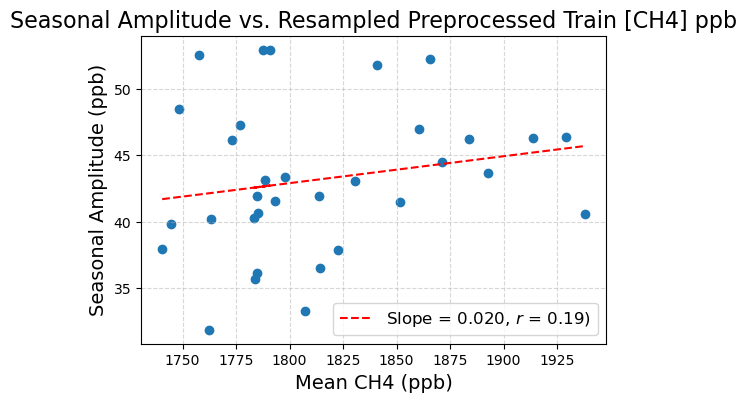

In [22]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the preprocessed CH4 train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

# convert the pandas series to a DataFrame
train_prepro_df = train_preprocessed.to_frame(name='CH4')
train_prepro_df['year'] = train_prepro_df.index.year

# Group by year to compute mean and amplitude
yearly = train_prepro_df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)', fontsize=14)
plt.ylabel('Seasonal Amplitude (ppb)', fontsize=14)
plt.title('Seasonal Amplitude vs. Resampled Preprocessed Train [CH4] ppb', fontsize=16)

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=12)
plt.show()

**Interpretation of the seasonal amplitude vs mean preprocessed CH4 plot:**

- cleaned, full length data: slope = 0.059, r = 0.36
- resampled train data: slope = 0.050, r = 0.29
- resampled preprocessed train data: slope = 0.020, r = 0.19

The resampled preprocessed train data is what will be modeled and will focus on these results.  Outlier removal, smoothing and interpolation made seasonal amplitude more uniform.  

The low values for slope and the correlation coefficient suggests that the seasonality does not need to be modeled as multiplicative (changing variance of the seasonal amplitude with the increasing CH4 concentration).  So, transformation likely won't be necessary.  

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling resampling, outliers, and interpolation while preserving the seasonality and trend.  

The ADF and KPSS tests confirm that the data series is not stationary, which supports the positive trend and linear regression metrics observed in a previous notebook (see notebook 2_ch4_eda). Therefore, non-seasnal differencing will likely be necessary for good SARIMA model performance.    

STL decomposition provides visual confirmation of the positive trend and the regular, annual seasonality of atomospheric CH4 concentration.  The residuals are analyzed with the ACF and PACF plots.  

The ACF and PACF plots closely resemble those for the full length, cleaned data (see notebook 3_ch4_preprocessing_eda).  The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and mildly oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing and after the seasonal and trend components are removed.  Also notable is that lag 52 is marginally significant likely indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  The marginally significant lag 52 on both ACF and PACF plots suggest a seasonal order as well, possible P and/or Q = 1.  

Heteroscedasticity - both the Breusch-Pagan and White tests indicate that the residuals are not heteroscedastic, which is consistent with what was observed for the full length data.  Furthermore, the seasonal cycle amplitude vs preprocessed CH4 concentration show a very mild positive trend.  So, transformation is likely unnecessary, but may be tested for possible improvements in modeling performance.  

## Add back value_unc and qcflag

In [23]:
print(train.index[:5])
print(train_preprocessed.index[:5])

DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')


In [24]:
# add the preprocessed data as a new column in a DataFrame with value_unc and qcflag

# rename the preprocessed data for the DataFrame column name
train_preprocessed = train_preprocessed.rename('CH4_preprocessed')
test_preprocessed = test_preprocessed.rename('CH4_preprocessed')

# convert to DataFrame
train_preprocessed_df = pd.DataFrame(train_preprocessed)
test_preprocessed_df = pd.DataFrame(test_preprocessed)

# merge metadata (qcflag, value_unc) using nearest original observation, which is the resampled data dates
train_preprocessed_df = pd.merge_asof(
    left=train_preprocessed_df.sort_index(),
    right=train[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D') # nearest +/- 3 days
)

test_preprocessed_df = pd.merge_asof(
    left=test_preprocessed_df.sort_index(),
    right=test[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D')
)

In [25]:
train_preprocessed_df.tail()

CH4_preprocessed  value_unc qcflag
2023-12-03        1952.61250      0.575    ...
2023-12-10        1947.39875      0.575    ...
2023-12-17        1944.51750      0.575    ...
2023-12-24        1944.51750      0.575    ...
2023-12-31        1947.39875      0.575    ...

In [26]:
test_preprocessed_df.head()

CH4_preprocessed  value_unc qcflag
2024-01-07        1946.68750      0.575    ...
2024-01-14        1948.25750      0.575    ...
2024-01-21        1949.82750      0.575    ...
2024-01-28        1949.77875      0.575    ...
2024-02-04        1952.87000      0.575    ...

The train and test indexes are different from those of train_preprocessed and test_preprocessed because of resampling for regular weekly frequency by the GasPreprocessor class.  Since the GasPreprocessor was fit only on the CH4 (value) column, value_unc and qcflag data remain aligned to the original, irregular timestamps.  

To align these ancillary variables with the new weekly time base, pd.merge_asof() is used to join them to the nearest resampled index. The tolerance=pd.Timedelta('3D') parameter specifies that only matches within ±3 days of each resampled timestamp are accepted.

If no value_unc or qcflag observation exists within that 3-day window, the corresponding cell remains NaN. These NaN values indicate weeks without a nearby original measurement. Because these are ancillary variables used for optional weighting or quality control rather than core model features, the NaNs are left in place for now.

In [27]:
# verify dataset dimensions

print('train shape:', train.shape)
print('test shape:', test.shape)

print('train_preprocessed shape:', train_preprocessed.shape)
print('test_preprocessed shape:', test_preprocessed.shape)

print('train_preprocessed_df shape:', train_preprocessed_df.shape)
print('test_preprocessed_df shape:', test_preprocessed_df.shape)

train shape: (1722, 3)
test shape: (53, 3)
train_preprocessed shape: (1722,)
test_preprocessed shape: (52,)
train_preprocessed_df shape: (1722, 3)
test_preprocessed_df shape: (52, 3)


Verify lengths of datasets:

- Train: 1722 weeks (1722 weeks / 52 weeks/year = 33 years)
- Test: 52 weeks (52 weeks / 52 weeks/year = 1 year)
- The sum of weeks = 1774, which is 34 years. The cleaned CH4 data series spans 1991-2025, which is 34 years.

In [28]:
# Check the last training point vs first test point after preprocessed both series. 

print('Last train date:', train.index[-1])
print('First test date:', test.index[0])
print('Gap between train end and test start:', test.index[0] - train.index[-1])

print('\nLast train_preprocessed date:', train_preprocessed.index[-1])
print('First test_preprocessed date:', test_preprocessed.index[0])
print('Gap between train end and test start:', test_preprocessed.index[0] - train_preprocessed.index[-1])

print('\nLast train_preprocessed_df date:', train_preprocessed_df.index[-1])
print('First test_preprocessed_df date:', test_preprocessed_df.index[0])
print('Gap between train end and test start:', test_preprocessed_df.index[0] - train_preprocessed_df.index[-1])

Last train date: 2023-12-31 00:00:00
First test date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_preprocessed date: 2023-12-31 00:00:00
First test_preprocessed date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_preprocessed_df date: 2023-12-31 00:00:00
First test_preprocessed_df date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00


## Save the preprocessed train and test data

In [29]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [30]:
# save the preprocessed train data including 'CH4' (formerly 'value'), 'value_unc', and 'qcflag'
output_path = output_dir / 'CH4_train_preprocessed.csv'
(
    train_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data including 'CH4' (formerly 'value'), 'value_unc', and 'qcflag'
output_path = output_dir / 'CH4_test_preprocessed.csv'
(
    test_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {train_preprocessed_df.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {test_preprocessed_df.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (1722, 3)

CH4_test_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (52, 3)


# Preprocessing with log transformation


[INFO] Fitting preprocessing for CH4
[INFO] Starting fit() for CH4 | Resample freq = None (using existing index)
Raw data: 1722 points, 37 NaNs
Trimmed data: 1722 points, 37 NaNs
Data range after trimming: 1991-01-06 00:00:00 to 2023-12-31 00:00:00
[INFO] Applying log transformation.
After resampling: 1722 points, 37 NaNs
[INFO] Found 28 potential outliers using robust STL residuals.
After outlier removal: 1722 points, 65 NaNs
After smoothing: 1722 points, 0 NaNs
After interpolation: 1722 points, 0 NaNs


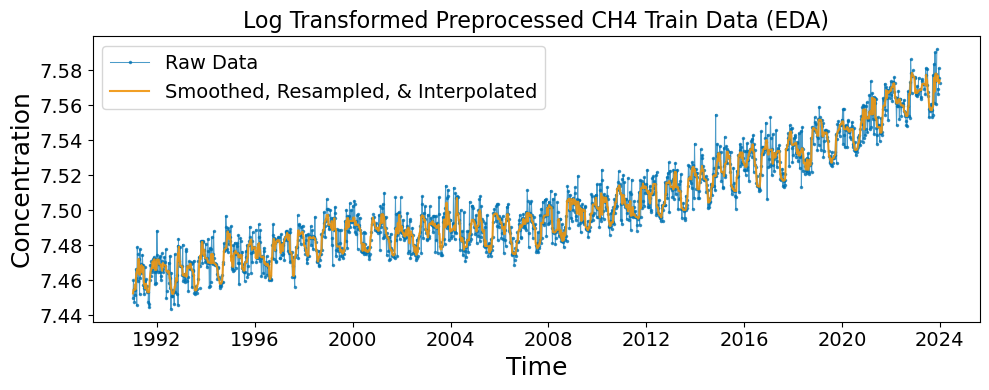

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.4111
ADF p-value 0.9082
ADF critical values: {'1%': -3.4342002032721437, '5%': -2.8632406484200064, '10%': -2.5676753800009053}

KPSS statistic 5.8430
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


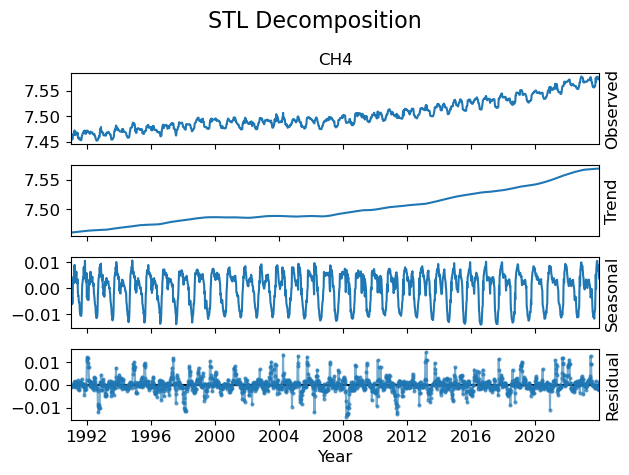

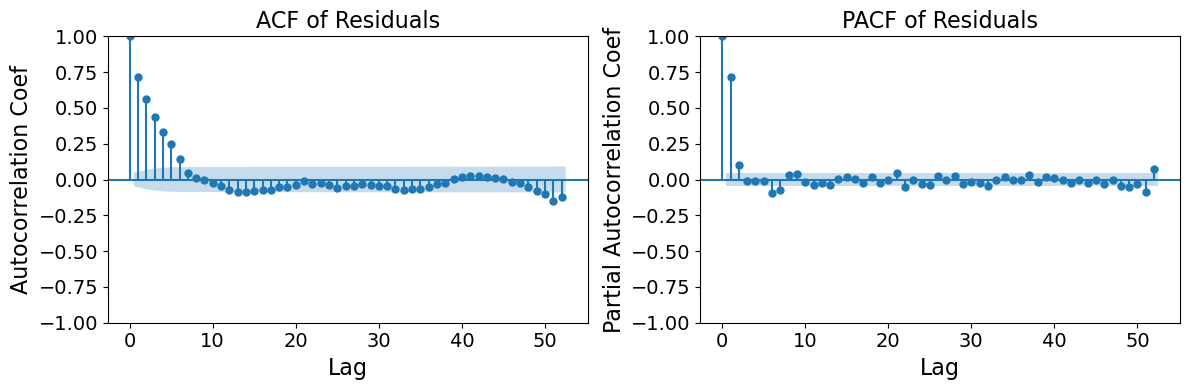


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.7331
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.8411
No heteroscedasticity detected (White test)
Adjusting test set dates to be contiguous with train set
[INFO] Dropping overlapping test point at 2023-12-31 00:00:00 (train end = 2023-12-31 00:00:00)


In [31]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

preprocessor_log = GasPreprocessor(
    gas_name='CH4', 
    iqr_factor=3.0,
    seasonal_period=52,
    do_eda=True,
    transformation='log'
)

train_log_preprocessed = preprocessor_log.fit_transform(
    train[['CH4']], 
    custom_title = 'Log Transformed Preprocessed CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
test_log_preprocessed = preprocessor_log.transform(test[['CH4']])

In [32]:
# verify data structure following transformation and preprocessing 

print('train shape:', train.shape)
print('test shape:', test.shape)

print('\ntrain_preprocessed shape:', train_preprocessed.shape)
print('CH4_tpreprocessed shape:', test_preprocessed.shape)

print('\ntrain_log_preprocessed shape:', train_log_preprocessed.shape)
print('test_log_preprocessed shape:', test_log_preprocessed.shape)

train shape: (1722, 3)
test shape: (53, 3)

train_preprocessed shape: (1722,)
CH4_tpreprocessed shape: (52,)

train_log_preprocessed shape: (1722,)
test_log_preprocessed shape: (52,)


In [33]:
# Check the last training point vs first test point after log and preprocessing both series. 

print('Last train_log_preprocessed date:', train_log_preprocessed.index[-1])
print('First test_log_preprocessed date:', test_log_preprocessed.index[0])
print('Gap between train end and test start:', test_log_preprocessed.index[0] - train_log_preprocessed.index[-1])

# Check for any NaN values that might cause issues
print(f'\ntrain_log_preprocessed NaN count: {train_log_preprocessed.isna().sum()}')
print(f'test_log_preprocessed NaN count: {test_log_preprocessed.isna().sum()}')

# Verify frequency is consistent
print(f'\ntrain_log_preprocessed frequency: {train_log_preprocessed.index.freq}')
print(f'test_log_preprocessed frequency: {test_log_preprocessed.index.freq}')

Last train_log_preprocessed date: 2023-12-31 00:00:00
First test_log_preprocessed date: 2024-01-07 00:00:00
Gap between train end and test start: 7 days 00:00:00

train_log_preprocessed NaN count: 0
test_log_preprocessed NaN count: 0

train_log_preprocessed frequency: <Week: weekday=6>
test_log_preprocessed frequency: <Week: weekday=6>


In [34]:
train_log_preprocessed.tail()

2023-12-03    7.576923
2023-12-10    7.574249
2023-12-17    7.572769
2023-12-24    7.572769
2023-12-31    7.574249
Freq: W-SUN, Name: CH4, dtype: float64

In [35]:
test_log_preprocessed.head()

2024-01-07    7.573884
2024-01-14    7.574690
2024-01-21    7.575496
2024-01-28    7.575470
2024-02-04    7.577055
Freq: W-SUN, Name: CH4, dtype: float64

## Determine if seasonal cycles are multiplicative

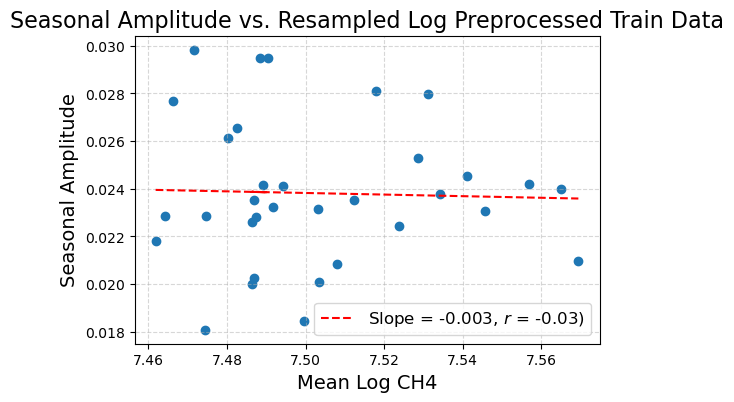

In [36]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the log preprocessed CH4 train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

# convert the pandas series to a DataFrame
train_log_prepro_df = train_log_preprocessed.to_frame(name='CH4')
train_log_prepro_df['year'] = train_log_prepro_df.index.year

# Group by year to compute mean and amplitude
yearly = train_log_prepro_df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean Log CH4', fontsize=14)
plt.ylabel('Seasonal Amplitude', fontsize=14)
plt.title('Seasonal Amplitude vs. Resampled Log Preprocessed Train Data', fontsize=16)

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=12)
plt.show()

**Interpretation of the seasonal amplitude vs mean log preprocessed CH4 plot:**

- cleaned, full length data: slope = 0.059, r = 0.36
- resampled train data: slope = 0.050, r = 0.29
- resampled preprocessed train data: slope = 0.020, r = 0.19
- resampled log preprocessed train data: slope = -0.003, r = -0.03

Log transformation made seasonal amplitude more uniform compared to the untransformed data.  The slope is basically 0.  

## Add back value_unc and qcflag to the log preprocessed data

In [37]:
# add the log preprocessed data as a new column in a DataFrame with value_unc and qcflag

# rename the preprocessed data for the DataFrame column name
train_log_preprocessed = train_log_preprocessed.rename('CH4_log_preprocessed')
test_log_preprocessed = test_log_preprocessed.rename('CH4_log_preprocessed')

# convert to DataFrame
train_log_preprocessed_df = pd.DataFrame(train_log_preprocessed)
test_log_preprocessed_df = pd.DataFrame(test_log_preprocessed)

# merge metadata (qcflag, value_unc) using nearest original observation, which is the resampled data dates
train_log_preprocessed_df = pd.merge_asof(
    left=train_log_preprocessed_df.sort_index(),
    right=train[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D') # nearest +/- 3 days
)

test_log_preprocessed_df = pd.merge_asof(
    left=test_log_preprocessed_df.sort_index(),
    right=test[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D')
)

In [38]:
train_log_preprocessed_df.tail()

CH4_log_preprocessed  value_unc qcflag
2023-12-03              7.576923      0.575    ...
2023-12-10              7.574249      0.575    ...
2023-12-17              7.572769      0.575    ...
2023-12-24              7.572769      0.575    ...
2023-12-31              7.574249      0.575    ...

In [39]:
test_log_preprocessed_df.head()

CH4_log_preprocessed  value_unc qcflag
2024-01-07              7.573884      0.575    ...
2024-01-14              7.574690      0.575    ...
2024-01-21              7.575496      0.575    ...
2024-01-28              7.575470      0.575    ...
2024-02-04              7.577055      0.575    ...

## Save log and preprocessed data for forecasting

In [40]:
# save the log preprocessed train and test data including 'CH4' (formerly 'value'), 'value_unc', and 'qcflag'
# note: CH4 (value) is log transformed while value_unc and qcflag are not.

output_path = output_dir / 'CH4_train_log_preprocessed.csv'
(
    train_log_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

output_path = output_dir / 'CH4_test_log_preprocessed.csv'
(
    test_log_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_log_preprocessed data saved to:\n{output_path}')
print(f'Shape: {train_log_preprocessed_df.shape}')
print(f'\nCH4_test_log_preprocessed data saved to:\n{output_path}')
print(f'Shape: {test_log_preprocessed_df.shape}')

CH4_train_log_preprocessed data saved to:
..\data\processed\CH4_test_log_preprocessed.csv
Shape: (1722, 3)

CH4_test_log_preprocessed data saved to:
..\data\processed\CH4_test_log_preprocessed.csv
Shape: (52, 3)


# Difference preprocessed train data +/- log transformation

Original series length: 1722
Non-seasonally differenced series length: 1721
Non-seasonally differenced log series length: 1721

[INFO] Stationarity tests on non-seasonally differenced series:
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -12.4675
ADF p-value 0.0000
ADF critical values: {'1%': -3.4342047424645092, '5%': -2.8632426521042587, '10%': -2.5676764469249473}

KPSS statistic 0.0226
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


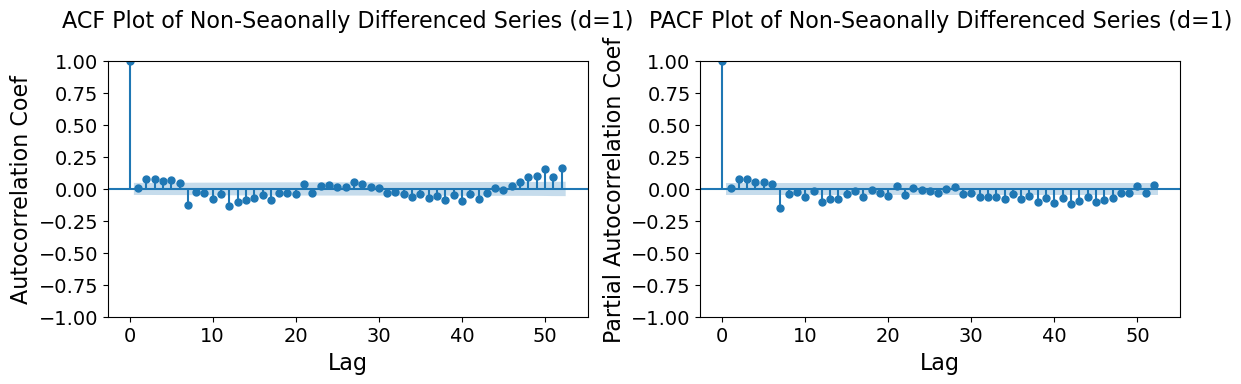


[INFO] Stationarity tests on non-seasonally differenced log series:


C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for non-seasonally differenced:
ADF statistic -12.4951
ADF p-value 0.0000
ADF critical values: {'1%': -3.4342047424645092, '5%': -2.8632426521042587, '10%': -2.5676764469249473}

KPSS statistic 0.0196
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



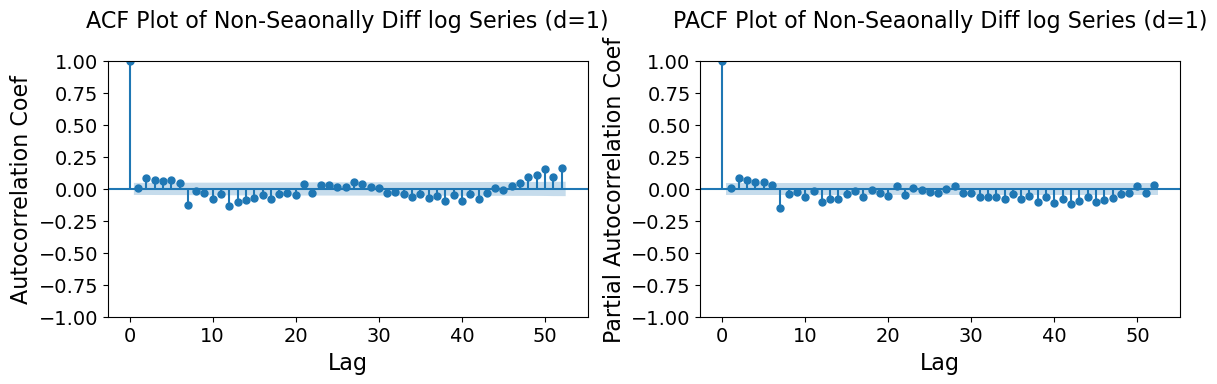

In [41]:
# inspect the residuals of non-seasonally differenced preprocessed train data +/- log transformation
# to determine its effectiveness

nsdiffed_series = train_preprocessed.diff(1).dropna()
nsdiffed_log_series = train_log_preprocessed.diff(1).dropna()

print(f'Original series length: {len(train_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')
print(f'Non-seasonally differenced log series length: {len(nsdiffed_log_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on non-seasonally differenced series:')
preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')

# stationarity tests - log transformed series
print('\n[INFO] Stationarity tests on non-seasonally differenced log series:')
preprocessor_log._run_stationarity_tests(nsdiffed_log_series, 'non-seasonally differenced')

# plot ACF and PACF - log transformed series
preprocessor_log.plot_acf_pacf(nsdiffed_log_series, 'Non-Seaonally Diff log Series (d=1)')

**Interpretation of non-seasonal differencing**

After non-seasonal differencing (d = 1), the log transformed and preprocessed train data is now stationary according to both the ADF and KPSS tests. So, non-seasonal differencing effectively removes the trend.  This is further supported by the stationarity tests for the seasonally differenced and both non-seasonally and seasonally differenced data that shows non-stationarity and stationarity, respecitively (see below).  

ACF and PACF plot results:  
1. non-log and log plots look nearly identical, which means that log transformation didn't change the autocorrelation structure (serial dependence).
2. The spike at lag 52 in the ACF plot but not the PACF plot indicates a seasonal MA component, a seasonal shock that persissts in the ACF but not PACF plot.  Therefore Q > 0.
3. The spikes at lags ~ 7 and ~ 12 may be indicating seasonal structure since they are close to being multiples of 52.  Low-order non-seasonal AR and/or MA terms (p and/or q) would need to be investigated for optimal model parameters.
4. Since neither the ACF or PACF plots have a clean, single cutoff, the process is likely a mix of AR and MA (ARMA).
5. Slightly oscillatory behavior of the ACF lags indicates remaining 

Original series length: 1722
Seasonally differenced series length: 1670
Seasonally differenced log series length: 1670

[INFO] Stationarity tests on seasonally differenced series:
ADF and KPSS tests for seasonally differenced:
ADF statistic -5.4863
ADF p-value 0.0000
ADF critical values: {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}

KPSS statistic 1.3261
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced time series may be difference-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


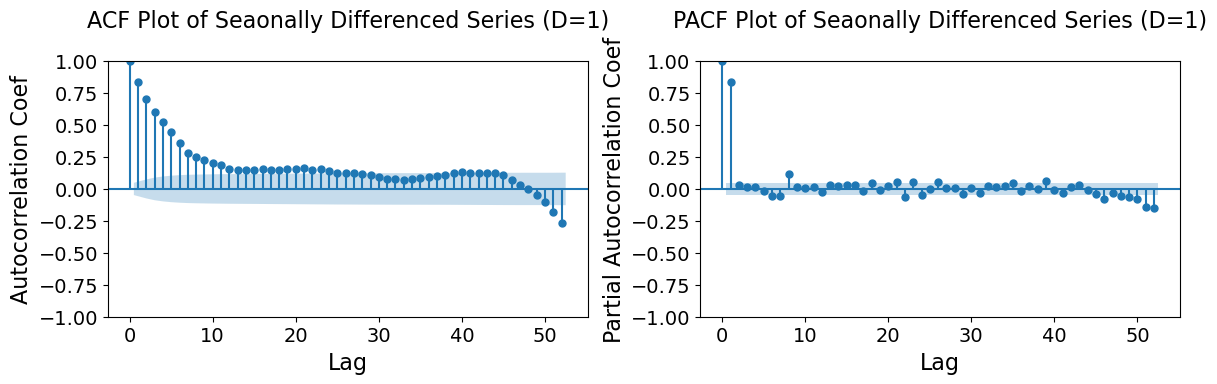

C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')



[INFO] Stationarity tests on seasonally differenced log series:
ADF and KPSS tests for seasonally differenced:
ADF statistic -5.5952
ADF p-value 0.0000
ADF critical values: {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}

KPSS statistic 1.1819
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced time series may be difference-stationary according to ADF and KPSS tests.



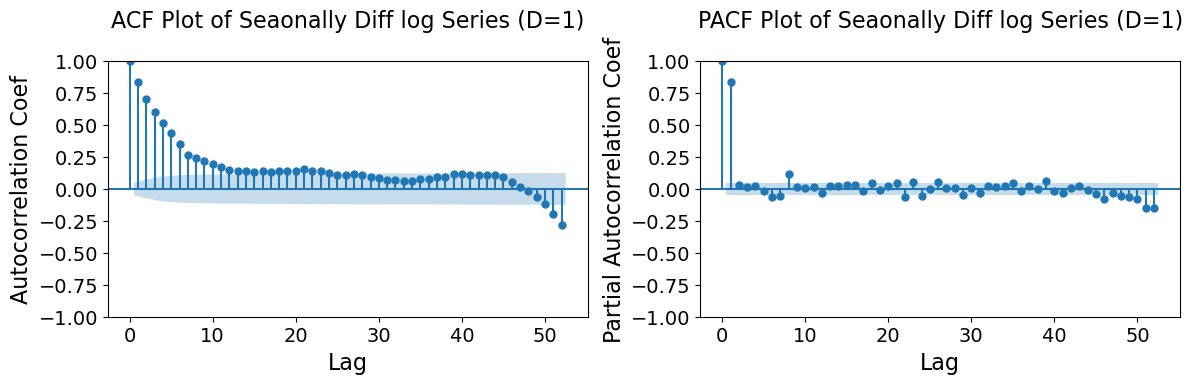

In [42]:
# inspect the residuals of seasonally differenced  (D=1) preprocessed train data +/- log transformation
# to determine its effectiveness

sdiffed_series = train_preprocessed.diff(52).dropna()
sdiffed_log_series = train_log_preprocessed.diff(52).dropna()

print(f'Original series length: {len(train_preprocessed)}')
print(f'Seasonally differenced series length: {len(sdiffed_series)}')
print(f'Seasonally differenced log series length: {len(sdiffed_log_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on seasonally differenced series:')
preprocessor._run_stationarity_tests(sdiffed_series, 'seasonally differenced')

# plot ACF and PACF
preprocessor.plot_acf_pacf(sdiffed_series, 'Seaonally Differenced Series (D=1)')

# stationarity tests - log transformed series
print('\n[INFO] Stationarity tests on seasonally differenced log series:')
preprocessor_log._run_stationarity_tests(sdiffed_log_series, 'seasonally differenced')

# plot ACF and PACF - log transformed series
preprocessor_log.plot_acf_pacf(sdiffed_log_series, 'Seaonally Diff log Series (D=1)')

**Interpretation of seasonal differencing**

After only seasonal differencing (D = 1), neither the non-log nor the log transformed data is now stationary according to both the ADF and KPSS tests.  Tests on both datasets indicate "may be difference-stationary).  Therefore some portion of the trend remains.  This is further supported by the stationarity tests for the non-seasonally differenced and both non-seasonally and seasonally differenced data that both show non-stationarity (see above and below, respectively).  

ACF and PACF plot results:  
1. non-log and log plots look nearly identical, which means that log transformation didn't change the autocorrelation structure (serial dependence).
2. Significatn spikes at lag 52 are seen in both the ACF and PACF plots indicating that a seasonal component remains as both an AR and MA component. Therefore P and Q > 0.
3. The spike at lag 7 in the PACF plot may be a multiple of 52. If so, it could be due to seasonal structure.  If not, the non-seaonsl AR terms should be explored (AR(p)).
4. Gradual decay of significant spikes in the ACF plot and sharp cutoff after lag 1 of the PACF plot suggest AR(1) structure.

Original series length: 1722
Seaonally & non-seasonally differenced series length: 1669
Seaonally & non-seasonally differenced log series length: 1669

[INFO] Stationarity tests on seasonally & non-seasonally differenced series:
ADF and KPSS tests for seasonally & non-seasonally differenced:
ADF statistic -12.2568
ADF p-value 0.0000
ADF critical values: {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}

KPSS statistic 0.0267
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally & non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


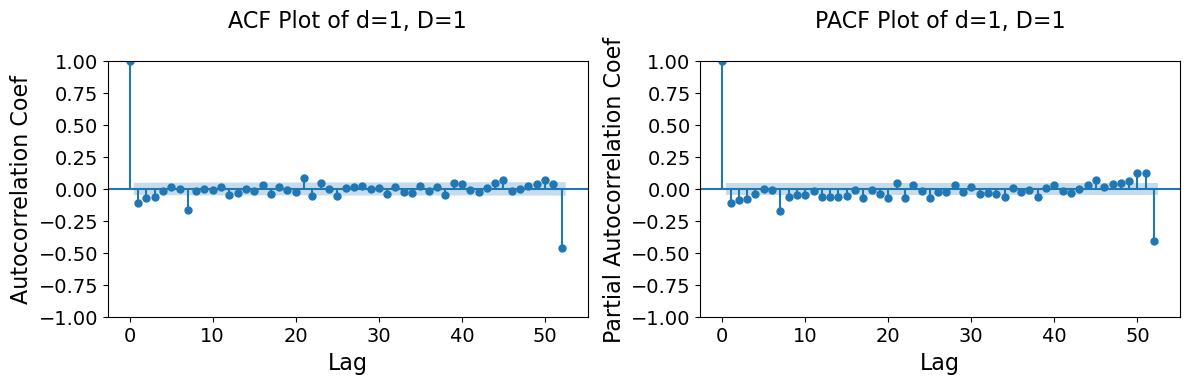


[INFO] Stationarity tests on seasonally & non-seasonally differenced log series:


C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:498: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for seasonally & non-seasonally differenced:
ADF statistic -12.2760
ADF p-value 0.0000
ADF critical values: {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}

KPSS statistic 0.0276
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally & non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



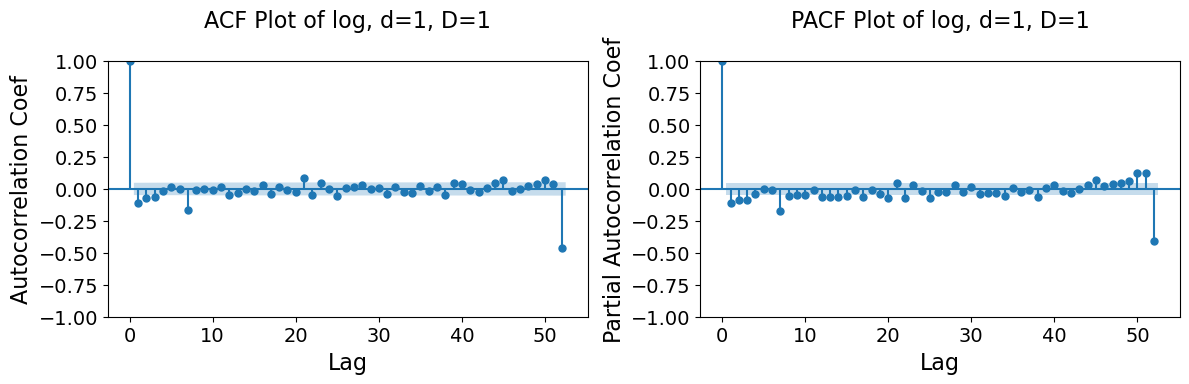

In [43]:
# Test the affect of non-seasonal and seasonal differencing (d=1, D=1), +/- log transformation

snsdiffed_series = nsdiffed_series.diff(52).dropna()

snsdiffed_series = nsdiffed_series.diff(52).dropna()
snsdiffed_log_series = nsdiffed_log_series.diff(52).dropna()

print(f'Original series length: {len(train_preprocessed)}')
print(f'Seaonally & non-seasonally differenced series length: {len(snsdiffed_series)}')
print(f'Seaonally & non-seasonally differenced log series length: {len(snsdiffed_log_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on seasonally & non-seasonally differenced series:')
preprocessor._run_stationarity_tests(snsdiffed_series, 'seasonally & non-seasonally differenced')

# plot ACF and PACF
preprocessor.plot_acf_pacf(snsdiffed_series, 'd=1, D=1')

# stationarity tests - log transformed series
print('\n[INFO] Stationarity tests on seasonally & non-seasonally differenced log series:')
preprocessor_log._run_stationarity_tests(snsdiffed_log_series, 'seasonally & non-seasonally differenced')

# plot ACF and PACF - log transformed series
preprocessor_log.plot_acf_pacf(snsdiffed_log_series, 'log, d=1, D=1')

**Interpretation of non-seasonal + seasonal differencing**

After differencing (d=1, D=1), both the non-log and the log transformed data are stationary according to both the ADF and KPSS tests.  This is further supported by the stationarity tests for the non-seasonally differenced and seasonally differenced data that show stationarity and non-stationarity, respectively (see above).

ACF and PACF plot results:  
1. non-log and log plots look nearly identical, which means that log transformation didn't change the autocorrelation structure (serial dependence).
2. Significant spikes at lag 52 are seen in both the ACF and PACF plots indicating that a seasonal component remains as both an AR and MA component. Therefore P and Q > 0.
3. The signficant spikes at lags 1, 2, and 7 in both the ACF and PACF plots suggest non-seasonal MA(1 or 2) and a non-seaonal AR(1 or 2), respectively.  
4. Since neither the ACF or PACF plots have a clean, single cutoff, the process is likely a mix of AR and MA (ARMA).

Note: Since log transformation did not signficantly change the serial dependence (non-log ACF and PACF nearly identical to log transformed ACF and PACF plots), transformation may not be crucial for the model, though it still may be helpful to stabilize variance if needed.  

**SARIMA models to consider from the results to this point:**

- SARIMA(1,1,1)(0,1,1,52)
- SARIMA(1,1,1)(1,1,0,52)
- SARIMA(1,1,1)(1,1,1,52)
- SARIMA(2,1,1)(0,1,1,52)
- etc

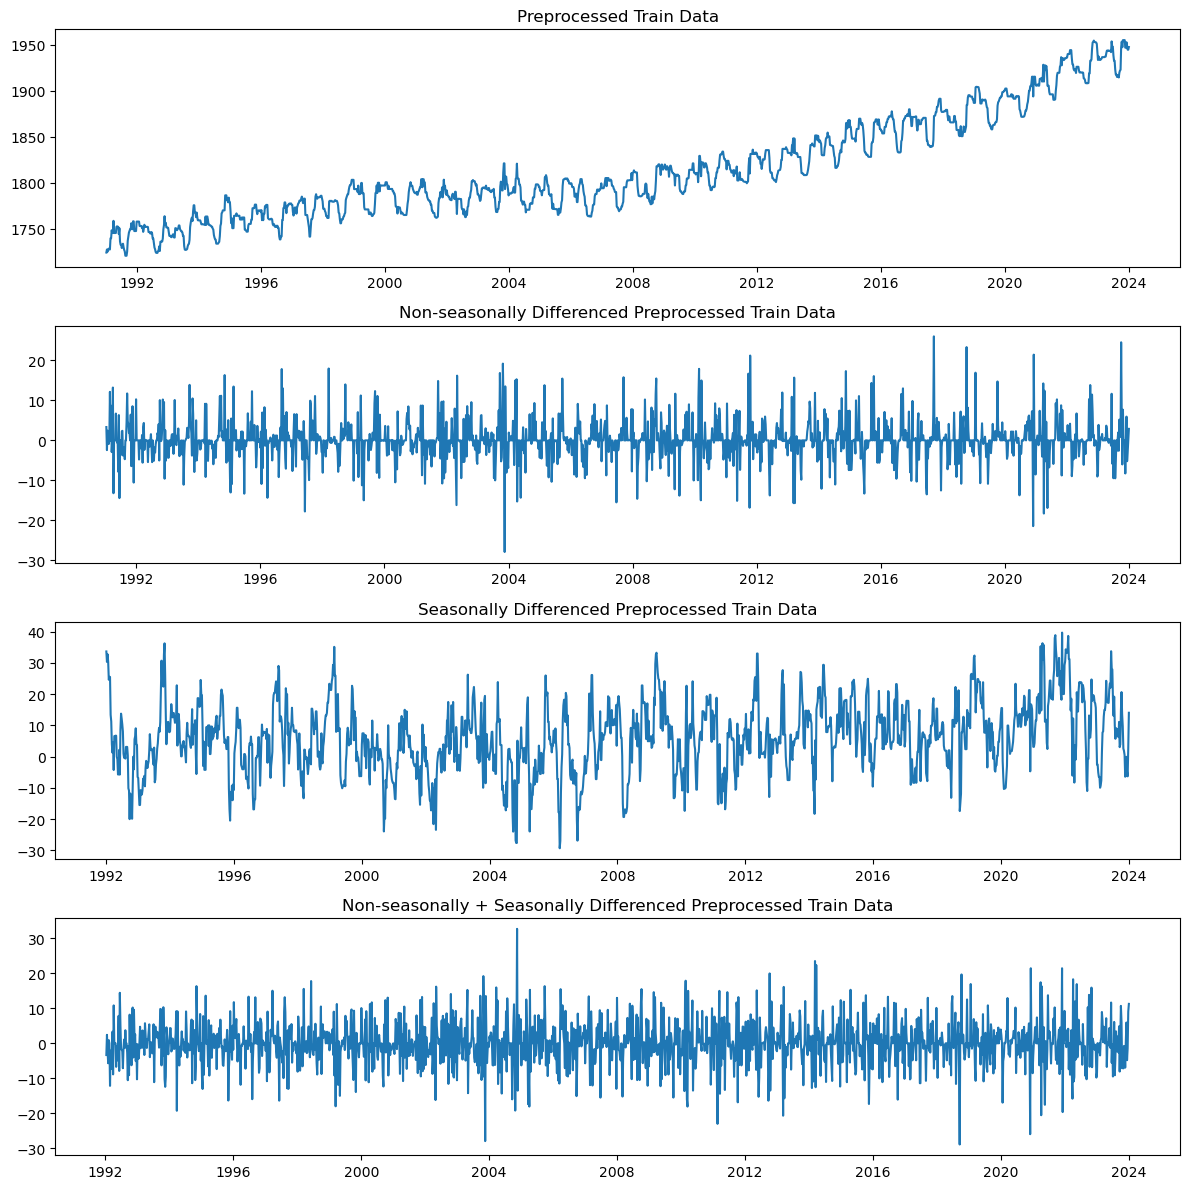

In [44]:
nsdiff = train_preprocessed.diff(1)
sdiff = train_preprocessed.diff(52)
snsdiff = nsdiff.diff(52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,12))
ax1.plot(train_preprocessed, label='train_prepro')
ax1.set_title('Preprocessed Train Data')

ax2.plot(nsdiff, label='train_prepro, nsdiff=1')
ax2.set_title('Non-seasonally Differenced Preprocessed Train Data')

ax3.plot(sdiff, label='train_prepro, sdiff=52')
ax3.set_title('Seasonally Differenced Preprocessed Train Data')

ax4.plot(snsdiff, label='train_prepro, ns+sdiff')
ax4.set_title('Non-seasonally + Seasonally Differenced Preprocessed Train Data')

plt.tight_layout()

# TimeSeriesSplit CV for validation

In [49]:
# Focus the model search on the d=1, D=1 ACF/PACF patterns

def get_models_from_acf_pacf():
    '''Generate models based on d=1,D=1 ACF/PACF patterns'''
    models = []
    
    # non-seasonal orders based on PACF decay to lag 7
    for p in range(1, 8):
        # non-seasonal MA based on ACF
        for q in range(0, 2):
            # seasonal orders based on spikes at 51,52
            for P in range(0, 2):
                for Q in range(0, 2):
                    models.append({
                        'order': (p, 1, q),
                        'seasonal_order': (P, 1, Q, 52)
                })
    return models

informed_models = get_models_from_acf_pacf()
print(f'Generated {len(informed_models)} models for evaluation\n')

models_df = pd.DataFrame(informed_models)
print(models_df)

Generated 56 models for evaluation

        order seasonal_order
0   (1, 1, 0)  (0, 1, 0, 52)
1   (1, 1, 0)  (0, 1, 1, 52)
2   (1, 1, 0)  (1, 1, 0, 52)
3   (1, 1, 0)  (1, 1, 1, 52)
4   (1, 1, 1)  (0, 1, 0, 52)
5   (1, 1, 1)  (0, 1, 1, 52)
6   (1, 1, 1)  (1, 1, 0, 52)
7   (1, 1, 1)  (1, 1, 1, 52)
8   (2, 1, 0)  (0, 1, 0, 52)
9   (2, 1, 0)  (0, 1, 1, 52)
10  (2, 1, 0)  (1, 1, 0, 52)
11  (2, 1, 0)  (1, 1, 1, 52)
12  (2, 1, 1)  (0, 1, 0, 52)
13  (2, 1, 1)  (0, 1, 1, 52)
14  (2, 1, 1)  (1, 1, 0, 52)
15  (2, 1, 1)  (1, 1, 1, 52)
16  (3, 1, 0)  (0, 1, 0, 52)
17  (3, 1, 0)  (0, 1, 1, 52)
18  (3, 1, 0)  (1, 1, 0, 52)
19  (3, 1, 0)  (1, 1, 1, 52)
20  (3, 1, 1)  (0, 1, 0, 52)
21  (3, 1, 1)  (0, 1, 1, 52)
22  (3, 1, 1)  (1, 1, 0, 52)
23  (3, 1, 1)  (1, 1, 1, 52)
24  (4, 1, 0)  (0, 1, 0, 52)
25  (4, 1, 0)  (0, 1, 1, 52)
26  (4, 1, 0)  (1, 1, 0, 52)
27  (4, 1, 0)  (1, 1, 1, 52)
28  (4, 1, 1)  (0, 1, 0, 52)
29  (4, 1, 1)  (0, 1, 1, 52)
30  (4, 1, 1)  (1, 1, 0, 52)
31  (4, 1, 1)  (1, 1, 1, 52)
32  (5,

## Trim train data to most recent 15 years

In [53]:
# Run TimeSeriesSplit on the most recent 15 years of train data

train_recent15 = train_preprocessed.loc['2009':]
train_log_recent15 = train_log_preprocessed.loc['2009':]

print(f'train_recent15 first date: {train_recent15.index[0]}')
print(f'train_recent15 final date: {train_recent15.index[-1]}')
print(f'length of train_recent15: {len(train_recent15)}')

print(f'\ntrain_log_recent15 first date: {train_log_recent15.index[0]}')
print(f'train_log_recent15 final date: {train_log_recent15.index[-1]}')
print(f'length of train_log_recent15: {len(train_log_recent15)}')

train_recent15 first date: 2009-01-04 00:00:00
train_recent15 final date: 2023-12-31 00:00:00
length of train_recent15: 783

train_log_recent15 first date: 2009-01-04 00:00:00
train_log_recent15 final date: 2023-12-31 00:00:00
length of train_log_recent15: 783


## TimeSeriesSplit CV on non-log train_recent15 data

In [54]:
# Run TimeSeriesSplit and analytics on non-log train_recent15 data

print('Starting model evaluation...')
candidate_model_results_df = evaluate_models_tscv(
    models_list=informed_models,
    data=train_recent15
)

sorted_candidate_models_df = candidate_model_results_df.sort_values(by='RMSE_mean')
print('Candidate models for train_recent15 set sorted by RMSE mean')
print(sorted_candidate_models_df)

Starting model evaluation...
Evaluating 56 models with 5 folds each
Total iterations: 280

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models: 100%|██████████| 56/56 [5:40:11<00:00, 364.49s/it]  


Total duration: 340.18 minutes
Average duration per model: 6.07 minutes

Number of models successfully evaluated: 56
Candidate models for train_recent15 set sorted by RMSE mean
        order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
6   (1, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.817114   
14  (2, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.823614   
38  (5, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.864650   
30  (4, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.864920   
46  (6, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.881563   
54  (7, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.905633   
20  (3, 1, 1)  (0, 1, 0, 52)                 5               1.0  20.916238   
12  (2, 1, 1)  (0, 1, 0, 52)                 5               1.0  20.920300   
4   (1, 1, 1)  (0, 1, 0, 52)                 5               1.0  20.946275   
36  (5, 1, 1)  (0, 1, 0, 52)    

**Interpretation of TimeSeriesSplit CV results**
1. 56 models were evaluated on the most recent 15 years of preprocessed train data (2009-2023) based on ACF and PACF plots of differenced train data.
2. All models converged on all 5 folds.
3. The top 16 models all have Q=0, srongly suggesting that seaonal MA terms do not improve the model fit.
4. The top six models based on RMSE (~ 20.8 ppb) all share the seasonal order (1,1,0)
5. The seasonal strength of the top models are all ~ 10.3 ppb.  Seasonal strength measures the standard deviation of forecasts and reflects the amplitude of predicted seasonal cycle.
6. Ljung-Box test p values for non-seasonal lags are all >> 0.05 (no autocorrelation).
7. Ljung_Box test p value for lag 52 is << 0.05, suggesting significant residual correlation at one year lag.  So, some seaonal structure remain in the residuals.
8. Results are nearly identical for the log transformed preprocessed train data (not shown), with slightly different non-seasonal and seaonal orders.  However, similar to the non-log data, All top models for the log-transformed data have seaonal MA(Q=0).

The most important next step is to improve model parameters to better capture the seasonal structure.  The following three approaches will be considered/tested, in order:
1. Run TimeSeriesSplit with the best non-seasonal orders (1,1,1) and expand the search specifically for seasonal orders.
2. Exogenous seasonal terms:  either month dummy variables, Fourier terms, or lag 52 specifically (CH4.shift(52))
3. Exogenous climate variables (temperature, ENSO index, NAO)

### In-sample residual analysis 


--- In-Sample Accuracy ---
RMSE: 72.845
MAE:  7.438
MAPE: 0.40%
R2:   -1.853


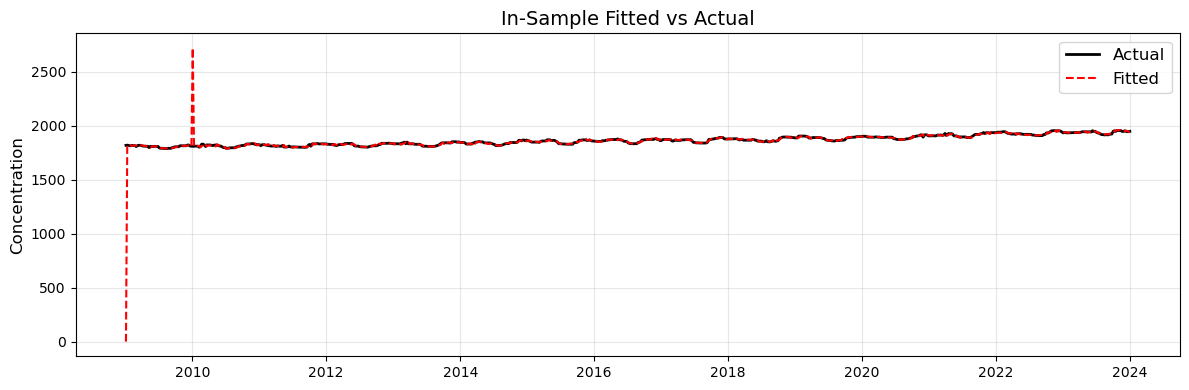

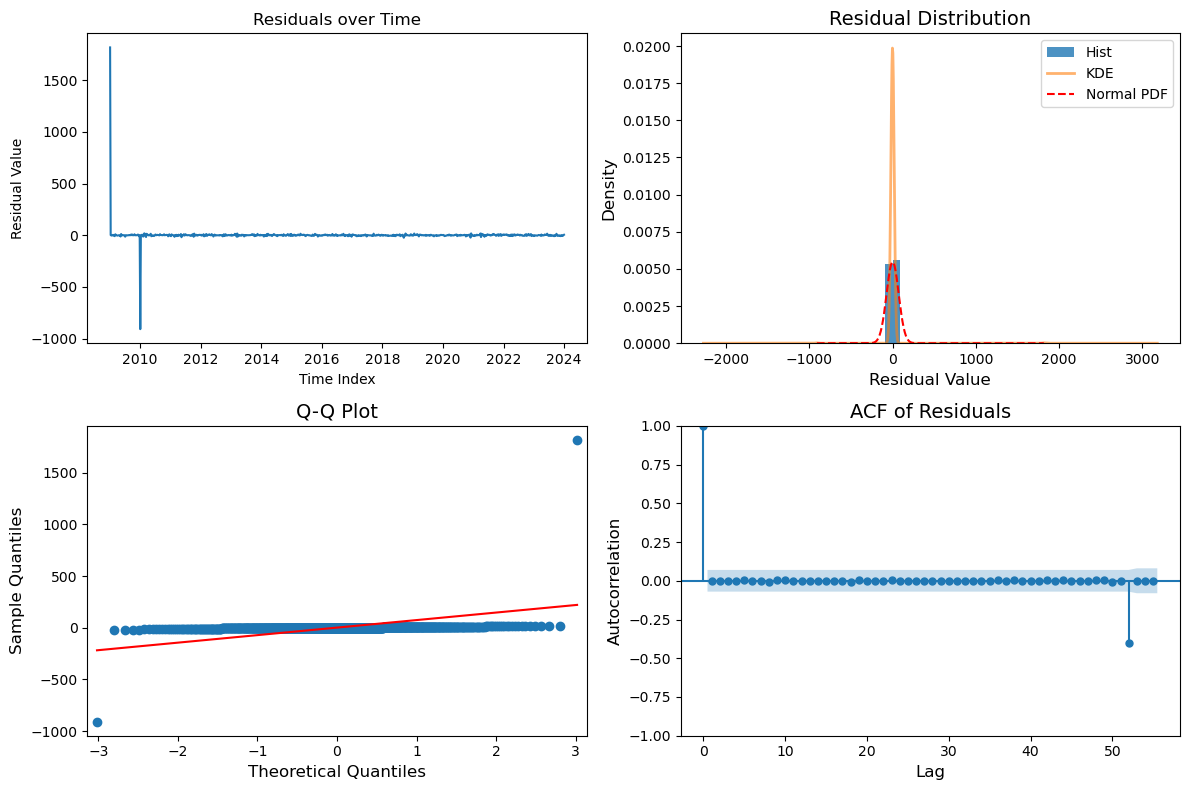


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 8944053.95
	p = 0.0000
	Skewness = 17.324
	kurtosis = 525.443

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9619
	lag 4: p = 1.0000
	lag 13: p = 1.0000
	lag 26: p = 1.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.9913
	Lag 4: p-value = 1.0000
	Lag 8: p-value = 1.0000
	Lag 12: p-value = 1.0000
	Lag 26: p-value = 1.0000

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.0409
White: p = 0.0054


In [74]:
# I will run an analysis on the best non-log SARIMA model by RMSE

SARIMA111110 = in_sample_resid_analysis(
    train_recent15,
    order=(1,1,1),
    seasonal_order=(1,1,0,52),
    run_hetero=True
)

In [75]:
# check location of the two spikes

print(f'First datapoint is at: {SARIMA111110.resid.index[0]}')
print(f'First spike is at: {SARIMA111110.resid.idxmax()}')
print(f'Second spike is at: {SARIMA111110.resid.idxmin()}')

First datapoint is at: 2009-01-04 00:00:00
First spike is at: 2009-01-04 00:00:00
Second spike is at: 2010-01-03 00:00:00


**Interpretation of in-sample residual analysis**
1. Two substantial spikes in the residuals.  They are at the first time point of each of the first two years of the data subset (train_recent15).  These spikes are likely artifacts considering that there are no obvious anomolous concentration readings in these regions of the data.  The first spike is likely due to the warm-up period of the SARIMA model, especially on data that is preprocessed and differernced.  The location of the second spike in addition to the substantial spike at lag 52 in the ACF plot hints at seasonal differencing issues.  I will attempt to tune the seasonal orders to reduce or eliminate this problem.

2. The data distribution deviates from normality with heavy tails.  The likely reason for these tails are the two extreme spikes noted above.  The first spike is positive, while the second spike is negative, which is likely the reason for the skewness = 17.  

3. The Ljung-Box test for autocorrelation up to the specific lags shows no autocorrelation at any lag except 52.  The model sucessfully captures short and medium-term patterns.  However, seasonal structure remains in the residuals.  This was noted in the TimeSeriesSplit CV analytics for all 56 models, and is corroborated in the ACF plot.

4. The ACF plot shows a significant spike at lag 52, flagging remaining seasonal structure.

5. The Engle's ARCH test finds no conditional variance, which means that modeling volatility won't be necessary.

6. The Breusch-Pagan and White tests p-values are both <0.05, thus rejecting the null hyptheses of no heteroscedasticity.  In contrast to the conditinal heteroscedasticity (clustered volatility) tested by Engle's ARCH test, Breusch-Pagan and White tests detects unconditional hetereoscedasticity.  The results indicate that the variance changes with the concentration of the data. I will run the in-sample residual analysis on the log transformed subset (train_log_recent15) and look for any improvements in heteroscesticity.  

7. Interestingly, the MAE and MAPE values are very low, meaning that the fitted values are very close to the actual values.  However, the RMSE value is substantialy higher than the MAE.  RMSE is sensitive to outliers and therefore likely reflects that early spikes.  


--- In-Sample Accuracy ---
RMSE: 0.300
MAE:  0.017
MAPE: 0.22%
R2:   -167.952


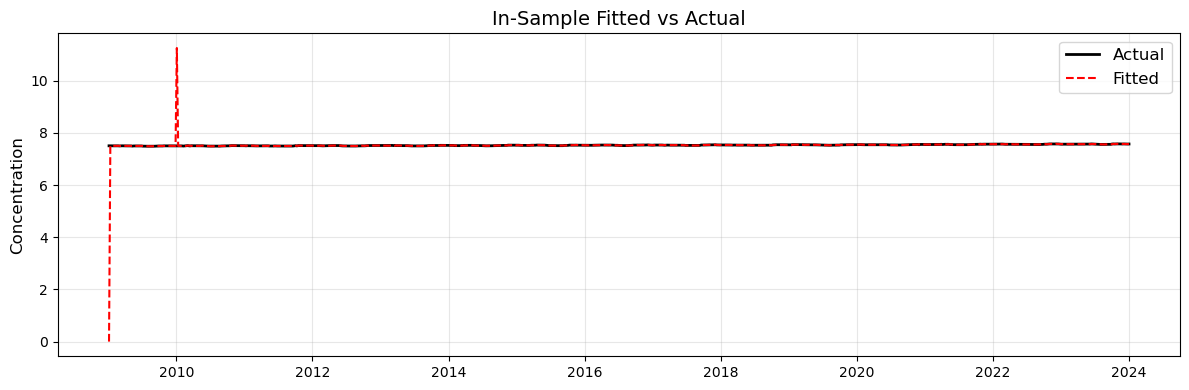

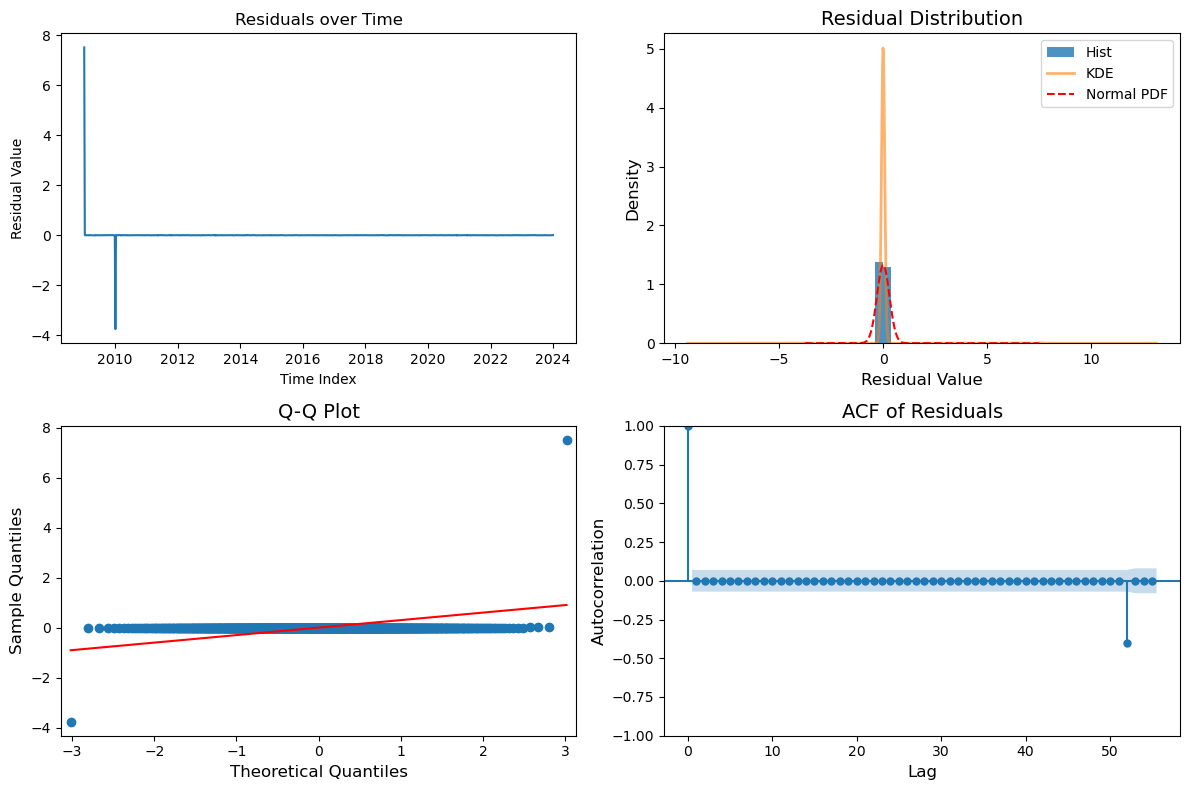


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 9151785.68
	p = 0.0000
	Skewness = 17.475
	kurtosis = 531.482

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9894
	lag 4: p = 1.0000
	lag 13: p = 1.0000
	lag 26: p = 1.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.9915
	Lag 4: p-value = 1.0000
	Lag 8: p-value = 1.0000
	Lag 12: p-value = 1.0000
	Lag 26: p-value = 1.0000

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.0410
White: p = 0.0054


In [76]:
# I will run an analysis on the log transformed data, train_log_recent15, to determine affect on heteroscedasticity.

SARIMA111110 = in_sample_resid_analysis(
    train_log_recent15,
    order=(1,1,1),
    seasonal_order=(1,1,0,52),
    run_hetero=True
)

**Interpretation of the model residuals on log-transformed data**
- log-transformation did not appreciably change the interpretation of the metrics, remove spikes, or alleviate heteroscedasticity.  So, I will proceed with the non-log data.  

## TimeSeriesSplit to tune seasonal orders

In [57]:
# Run TimeSeriesSplit with the best non-seasonal orders (1,1,1) and expand the search specifically for seasonal orders.
# One important question from the previous TimeSeriesSplit results where d=1 and D=1 is if the latter is over differencing.  
# So, I will include D=0 in the search for more optimal seasonal orders.

def get_models_from_acf_pacf():
    '''Generate candidate models with combinations of orders in specified range'''
    models = []
    
    for P in range(0, 4):
        for D in [0, 1]:
            for Q in range(0, 4):
                # skip redundant combinations
                    models.append({
                        'order': (1, 1, 1),
                        'seasonal_order': (P, D, Q, 52)
                    })
    return models

revised_models = get_models_from_acf_pacf()
print(f'Generated {len(revised_models)} models for evaluation\n')

models_df = pd.DataFrame(revised_models)
print(models_df)

Generated 32 models for evaluation

        order seasonal_order
0   (1, 1, 1)  (0, 0, 0, 52)
1   (1, 1, 1)  (0, 0, 1, 52)
2   (1, 1, 1)  (0, 0, 2, 52)
3   (1, 1, 1)  (0, 0, 3, 52)
4   (1, 1, 1)  (0, 1, 0, 52)
5   (1, 1, 1)  (0, 1, 1, 52)
6   (1, 1, 1)  (0, 1, 2, 52)
7   (1, 1, 1)  (0, 1, 3, 52)
8   (1, 1, 1)  (1, 0, 0, 52)
9   (1, 1, 1)  (1, 0, 1, 52)
10  (1, 1, 1)  (1, 0, 2, 52)
11  (1, 1, 1)  (1, 0, 3, 52)
12  (1, 1, 1)  (1, 1, 0, 52)
13  (1, 1, 1)  (1, 1, 1, 52)
14  (1, 1, 1)  (1, 1, 2, 52)
15  (1, 1, 1)  (1, 1, 3, 52)
16  (1, 1, 1)  (2, 0, 0, 52)
17  (1, 1, 1)  (2, 0, 1, 52)
18  (1, 1, 1)  (2, 0, 2, 52)
19  (1, 1, 1)  (2, 0, 3, 52)
20  (1, 1, 1)  (2, 1, 0, 52)
21  (1, 1, 1)  (2, 1, 1, 52)
22  (1, 1, 1)  (2, 1, 2, 52)
23  (1, 1, 1)  (2, 1, 3, 52)
24  (1, 1, 1)  (3, 0, 0, 52)
25  (1, 1, 1)  (3, 0, 1, 52)
26  (1, 1, 1)  (3, 0, 2, 52)
27  (1, 1, 1)  (3, 0, 3, 52)
28  (1, 1, 1)  (3, 1, 0, 52)
29  (1, 1, 1)  (3, 1, 1, 52)
30  (1, 1, 1)  (3, 1, 2, 52)
31  (1, 1, 1)  (3, 1, 3, 52)


In [58]:
# Run TimeSeriesSplit CV on models list to find more optimal seasonal orders

print('Starting model evaluation...')
revised_model_results_df = evaluate_models_tscv(
    models_list=revised_models,
    data=train_recent15
)

sorted_revised_models_df = revised_model_results_df.sort_values(by='RMSE_mean')
print('Revised candidate models for train set sorted by RMSE mean')
print(sorted_revised_models_df)

Starting model evaluation...
Evaluating 32 models with 5 folds each
Total iterations: 160

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models:  28%|██▊       | 9/32 [43:01<2:13:10, 347.42s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (1, 1, 1), (1, 0, 1, 52) did not converge on fold 4


Models:  31%|███▏      | 10/32 [46:46<1:53:27, 309.43s/it]

Model (1, 1, 1), (1, 0, 2, 52) failed on fold 4: LU decomposition error.


Models:  34%|███▍      | 11/32 [57:58<2:27:08, 420.41s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (1, 1, 1), (1, 0, 3, 52) did not converge on fold 4


Models:  53%|█████▎    | 17/32 [2:23:22<2:57:59, 712.00s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (1, 1, 1), (2, 0, 1, 52) did not converge on fold 4


Models:  56%|█████▋    | 18/32 [2:41:52<3:14:00, 831.47s/it]

Model (1, 1, 1), (2, 0, 2, 52) failed on fold 1: LU decomposition error.
Model (1, 1, 1), (2, 0, 2, 52) failed on fold 3: LU decomposition error.


Models:  84%|████████▍ | 27/32 [5:26:55<1:39:20, 1192.05s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (1, 1, 1), (3, 0, 3, 52) did not converge on fold 1


Models: 100%|██████████| 32/32 [7:54:41<00:00, 890.03s/it]   


Total duration: 474.69 minutes
Average duration per model: 14.83 minutes

Number of models successfully evaluated: 32
Revised candidate models for train set sorted by RMSE mean
        order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
0   (1, 1, 1)  (0, 0, 0, 52)                 5               1.0  17.835863   
8   (1, 1, 1)  (1, 0, 0, 52)                 5               1.0  19.942317   
1   (1, 1, 1)  (0, 0, 1, 52)                 5               1.0  19.992068   
9   (1, 1, 1)  (1, 0, 1, 52)                 4               0.8  20.697595   
2   (1, 1, 1)  (0, 0, 2, 52)                 5               1.0  20.778147   
16  (1, 1, 1)  (2, 0, 0, 52)                 5               1.0  20.796771   
12  (1, 1, 1)  (1, 1, 0, 52)                 5               1.0  20.817114   
11  (1, 1, 1)  (1, 0, 3, 52)                 4               0.8  20.891662   
4   (1, 1, 1)  (0, 1, 0, 52)                 5               1.0  20.946275   
10  (1, 1, 1)  (1, 0, 2, 52)    

Adding seasonal orders and differencing did not improve model performance on any metrics.  Models with D = 1 have significantly better p values for Ljung-Box p values at lag 52 compared to models with D = 2, though all are << 0.05.

I will try to fit SARIMAX with exogenous fouerier terms to model the seasonal structure.

**Interpretation of TimeSeriesSplit CV (tuned seasonal orders) results**
1. 32 models were evaluated on the most recent 15 years of preprocessed train data (2009-2023) based on ACF and PACF plots of differenced train data.
2. All models converged, though not on all 5 folds.
3. The top six models all have D=0, srongly suggesting that seaonal differencing does not improve the model fit.
4. The top two models, based on RMSE, also lack a seasonal MA term (Q=0), as seen in the first TimeSeriesSplit search where all models had D=1 (see above, TimeSeriesSplit CV on non-log train_recent15 data).
5. The RMSE of best models with D=0 is substantially lower than the top model with D=1 (~ 18 vs 21, respectively).
6. Importantly, there is an exact correlation of D=0 and a Ljung-Box p-value = 1 at lag 52.
7. The forecast volatility (seasonal strength) of the model with D=0 is substantially lower than that of the model with D=1 (3.4 vs 10.3, respectively).  So, D=1 was likely over-differencing the seasonal structure amplifying noise and/or leading to artifacts.

Nest step:  residual analysis of D=0 best model.  Look for affects on seasonal autocorrelation, anomalous spikes, residual distribution.

### In-sample residual analysis of best model where D=0

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



--- In-Sample Accuracy ---
RMSE: 65.156
MAE:  5.271
MAPE: 0.29%
R2:   -1.282


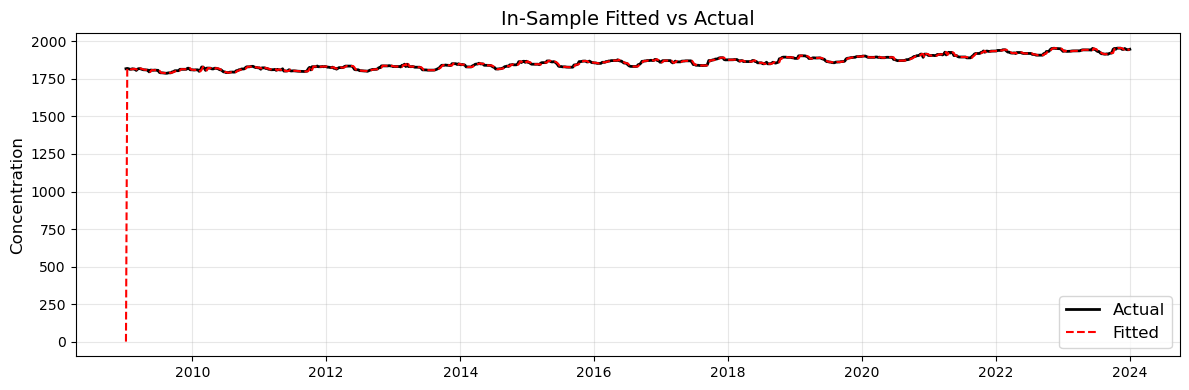

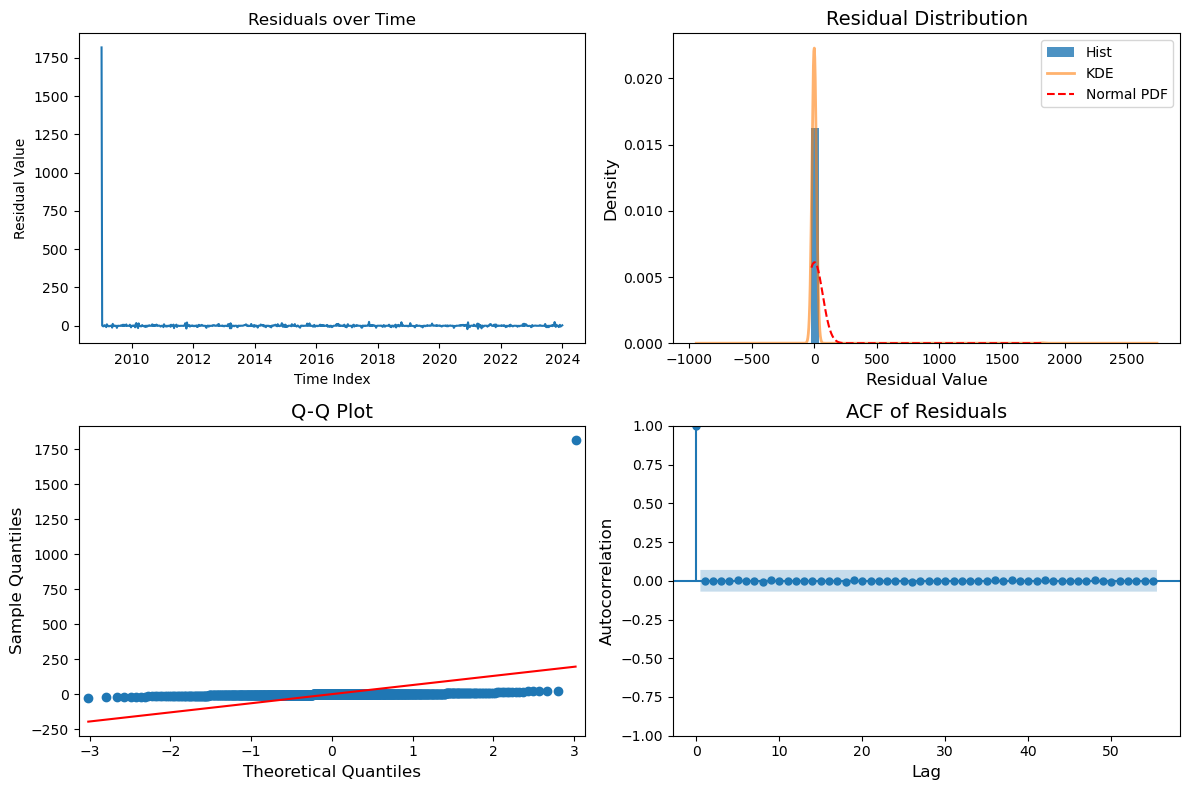


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 19378041.15
	p = 0.0000
	Skewness = 27.678
	kurtosis = 771.699

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9871
	lag 4: p = 1.0000
	lag 13: p = 1.0000
	lag 26: p = 1.0000
	lag 52: p = 1.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.9998
	Lag 4: p-value = 1.0000
	Lag 8: p-value = 1.0000
	Lag 12: p-value = 1.0000
	Lag 26: p-value = 1.0000

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.0835
White: p = 0.0186


In [78]:
# I will run an analysis on the best non-log SARIMA model - seasonal order tune

SARIMA111000 = in_sample_resid_analysis(
    train_recent15,
    order=(1,1,1),
    seasonal_order=(0,0,0,52),
    run_hetero=True
)

### Trim first residual

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 5.036
MAE:  2.953
MAPE: 0.16%
R2:   0.986


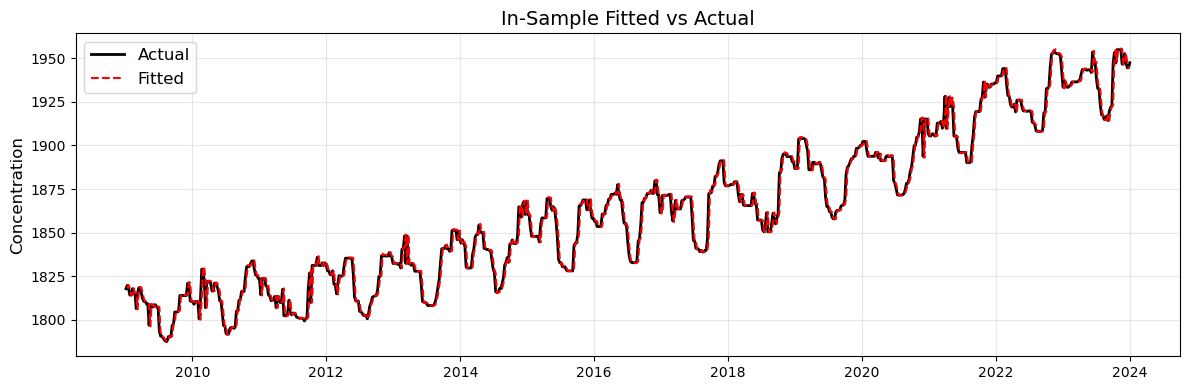

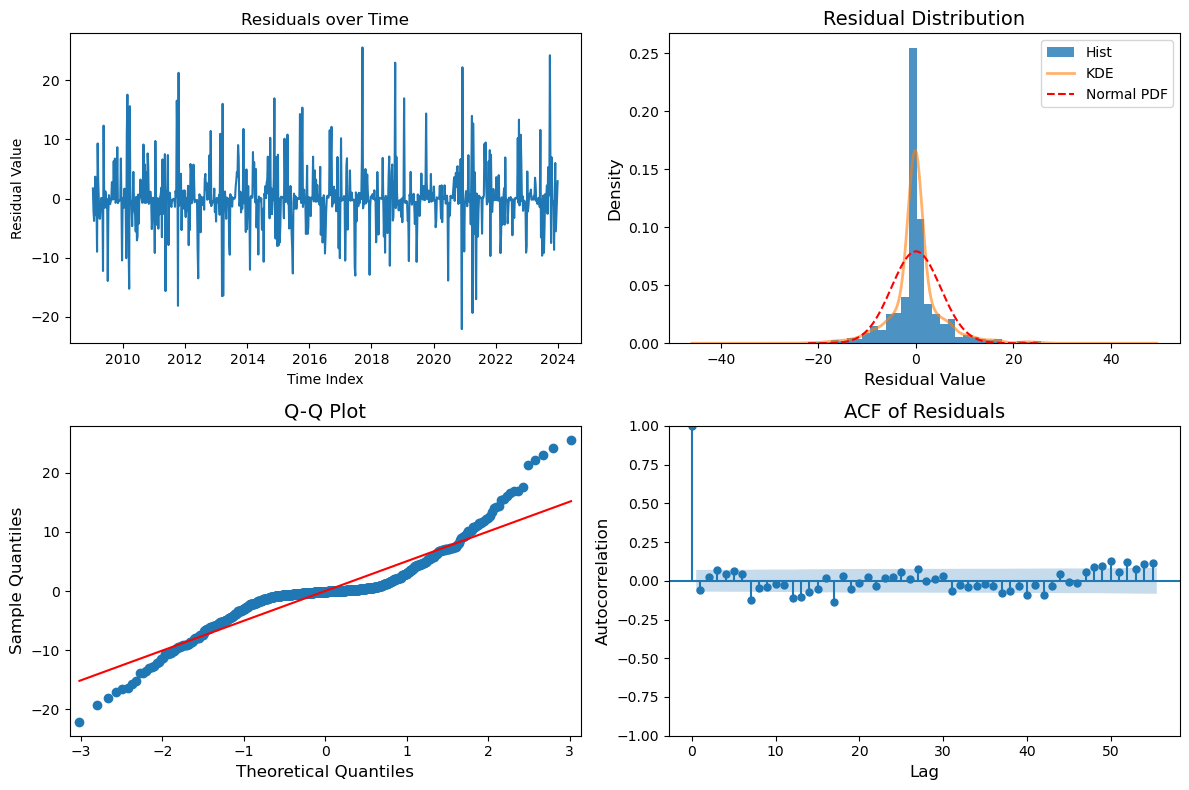


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 803.70
	p = 0.0000
	Skewness = 0.483
	kurtosis = 7.872

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.0961
	lag 4: p = 0.0794
	lag 13: p = 0.0000
	lag 26: p = 0.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0001***
	Lag 26: p-value = 0.0026***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.9144
White: p = 0.8840


In [79]:
# I will run an analysis on the same, best model from the TimeSeriesSplit seasonal 
# order tune.
# this residual analysis will exclude the first residual that presents as a substantial
# spike.

SARIMA111000 = in_sample_resid_analysis(
    train_recent15,
    order=(1,1,1),
    seasonal_order=(0,0,0,52),
    trim_first=True,
    run_hetero=True
)

**Interpretation of trimmed first residual**
- Trimming the first residual eliminated the initial spike.
- It also allowed for more informative scale and analytical metrics.

1. The fitted values closely and accurately follow the actual values.  The RMSE, MAE, MAPE, and R^2 values all substantially improved.

| Metric | With First Residual | Without First Residual |
|--------|---------------------|------------------------|
| RMSE | 65.16 | 5.06 |
| MAE | 5.27 | 2.95 |
| MAPE | 0.29% | 0.16% |
| R^2 | -1.28 | 0.99 |

2. The distribution is also improved. Although the residuals are still not normally distributed, they are far less skewed with less heavy tails (leptokurtic).   

| Metric | With First Residual | Without First Residual |
|--------|---------------------|------------------------|
| JB | 19378041 | 803.70 |
| p val | 0.0000 | 0.0000 |
| Skewness | 27.68 | 0.48 |
| Kurtosis | 771.70 | 7.87 |

3. Autocorrelation is now revealed for both mid-term and seasonal lags (13, 23, and 52) by the Ljung-Box test.  These may be due to remaining seasonality since the values were chosen to diagnose sub-seasonal autocorrelation (quarter, bi-anual, anual).  I will try to address this by increasing the model orders and/or including Fourier terms as an exogenous variable.   

4. The ACF plot shows significant lags at 7, 12, and 17, which could be interpreted as having monthly autocorrelation (~ 2 months, 3 months, and 4 months).  These lags are likely responsible for the Ljung-Box results described in 3.  Additional non-seaonal orders may address some or all of these problems, with the likely exception of lag 52.

5. Removing the first residual/spike also, and very importantly, revealed conditional heterscedasticity (volatility) according the the Engle's ARCH test.  GARCH modeling may be necessary for more accurate confidence intervals of the forecast.  


#### Model with increasing number of model orders

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.991
MAE:  3.034
MAPE: 0.16%
R2:   0.987


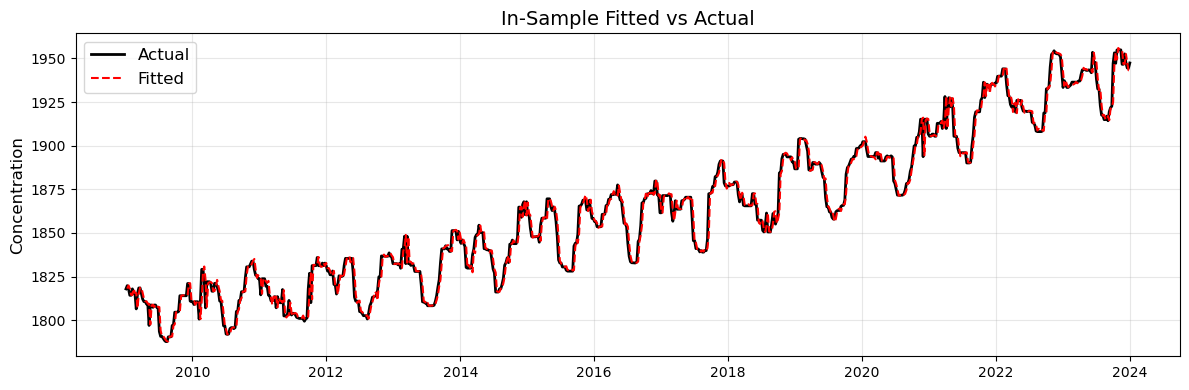

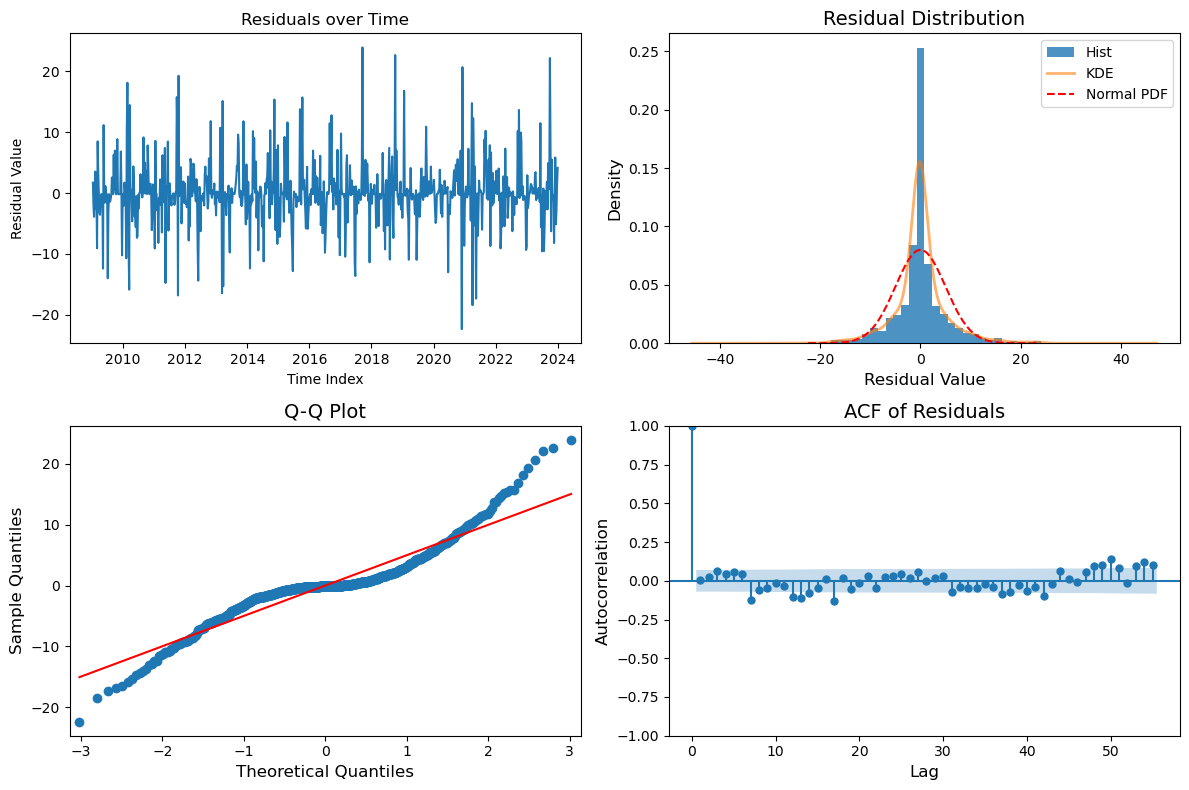


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 595.77
	p = 0.0000
	Skewness = 0.364
	kurtosis = 7.213

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9551
	lag 4: p = 0.2645
	lag 13: p = 0.0000
	lag 26: p = 0.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0001***
	Lag 26: p-value = 0.0010***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.9057
White: p = 0.8709


In [85]:
SARIMA111100 = in_sample_resid_analysis(
    train_recent15,
    order=(1,1,1),
    seasonal_order=(1,0,0,52),
    trim_first=True,
    run_hetero=True
)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.969
MAE:  3.066
MAPE: 0.16%
R2:   0.987


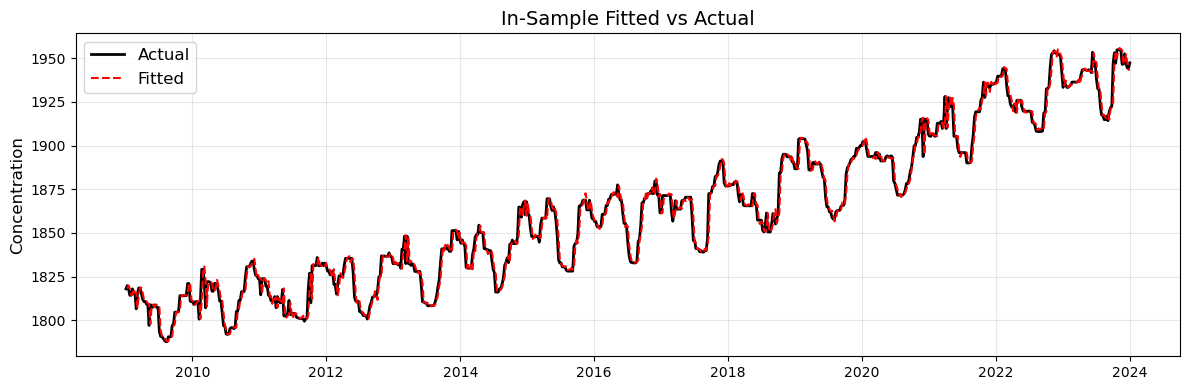

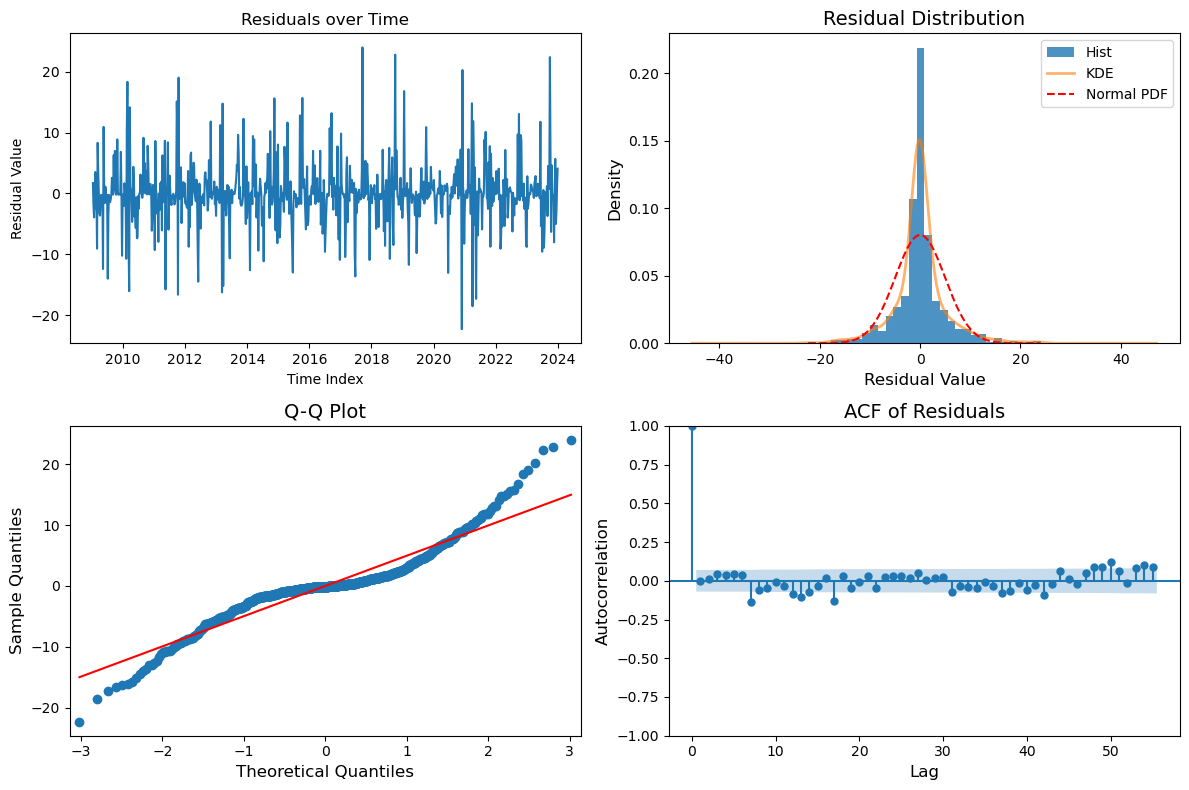


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 609.92
	p = 0.0000
	Skewness = 0.353
	kurtosis = 7.269

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9901
	lag 4: p = 0.6351
	lag 13: p = 0.0001
	lag 26: p = 0.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0001***
	Lag 12: p-value = 0.0002***
	Lag 26: p-value = 0.0015***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.7984
White: p = 0.8403


In [86]:
SARIMA111200 = in_sample_resid_analysis(
    train_recent15,
    order=(1,1,1),
    seasonal_order=(2,0,0,52),
    trim_first=True,
    run_hetero=True
)

Adding one seasonal order AR P=1 slightly improved the distribution.  P=2 also improved the distribution but not substantially.  I will try adding non-seasonal orders keeping P=1.  

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.979
MAE:  3.032
MAPE: 0.16%
R2:   0.987


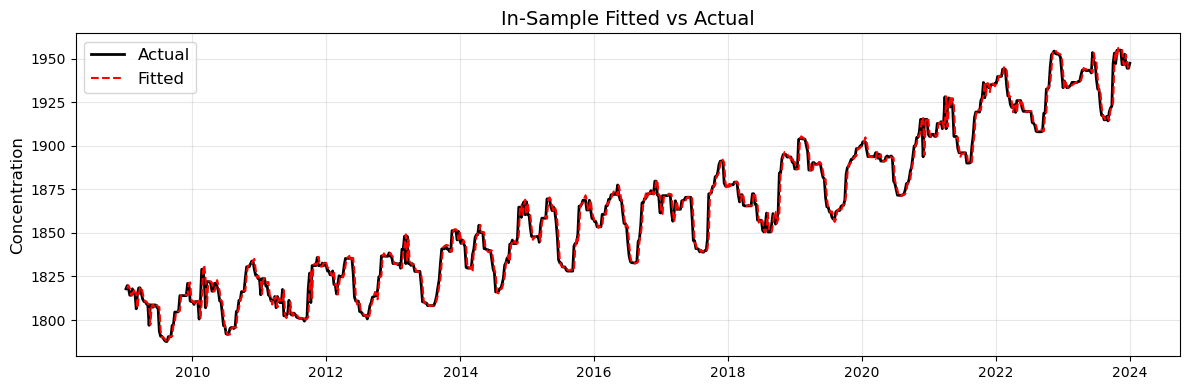

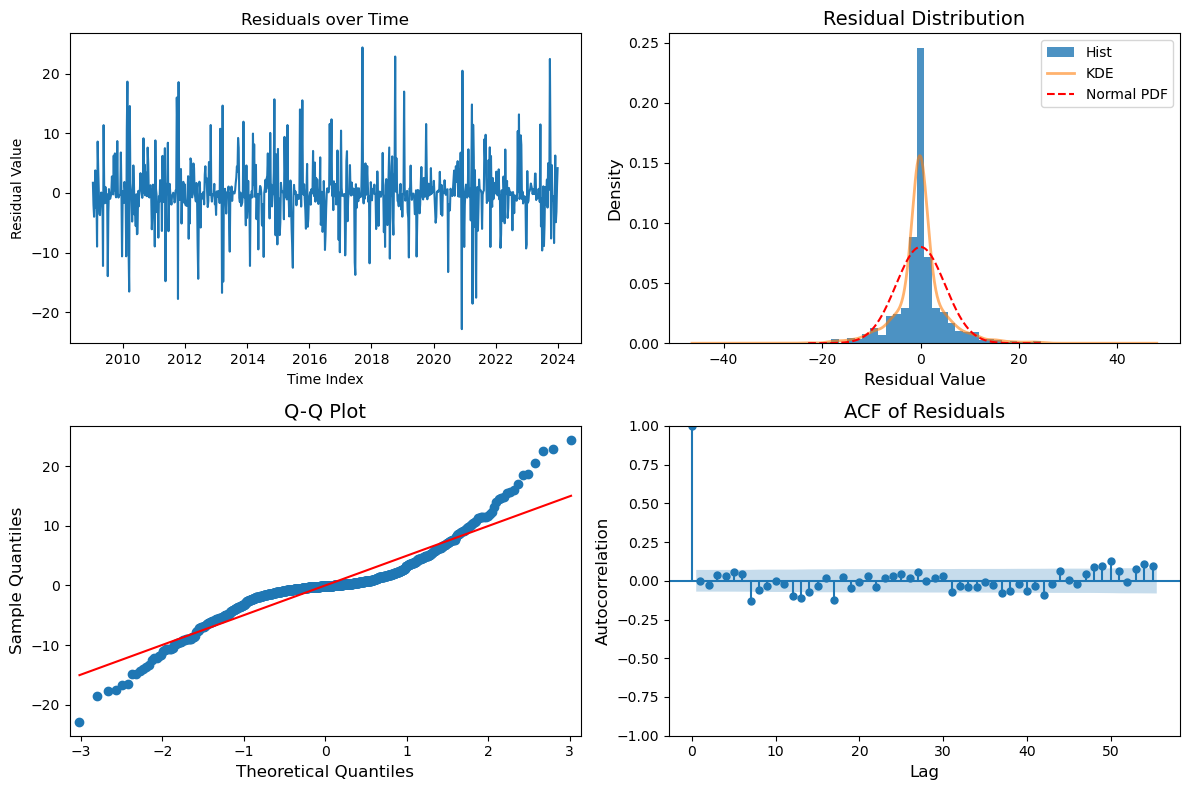


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 650.15
	p = 0.0000
	Skewness = 0.342
	kurtosis = 7.414

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9183
	lag 4: p = 0.6432
	lag 13: p = 0.0001
	lag 26: p = 0.0000
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0001***
	Lag 26: p-value = 0.0013***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.8680
White: p = 0.8542


In [87]:
SARIMA211000 = in_sample_resid_analysis(
    train_recent15,
    order=(2,1,1),
    seasonal_order=(1,0,0,52),
    trim_first=True,
    run_hetero=True
)

Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.971
MAE:  3.029
MAPE: 0.16%
R2:   0.987


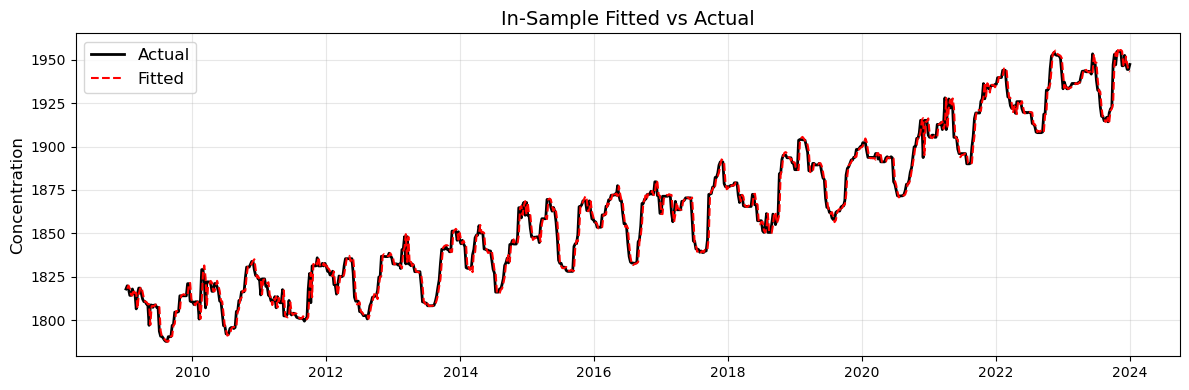

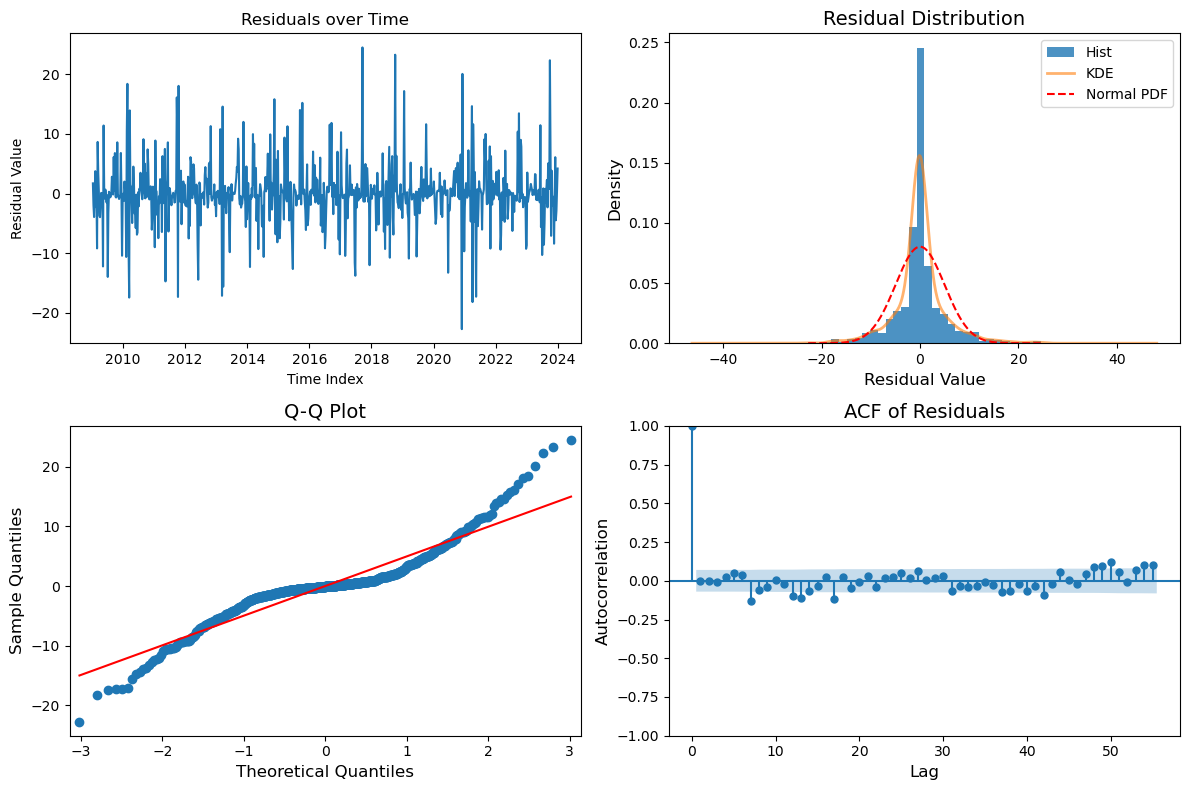


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 660.43
	p = 0.0000
	Skewness = 0.324
	kurtosis = 7.455

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9664
	lag 4: p = 0.9587
	lag 13: p = 0.0002
	lag 26: p = 0.0001
	lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0002***
	Lag 26: p-value = 0.0026***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.8155
White: p = 0.8652


In [88]:
SARIMA311000 = in_sample_resid_analysis(
    train_recent15,
    order=(3,1,1),
    seasonal_order=(1,0,0,52),
    trim_first=True,
    run_hetero=True
)

Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.776
MAE:  3.138
MAPE: 0.17%
R2:   0.988


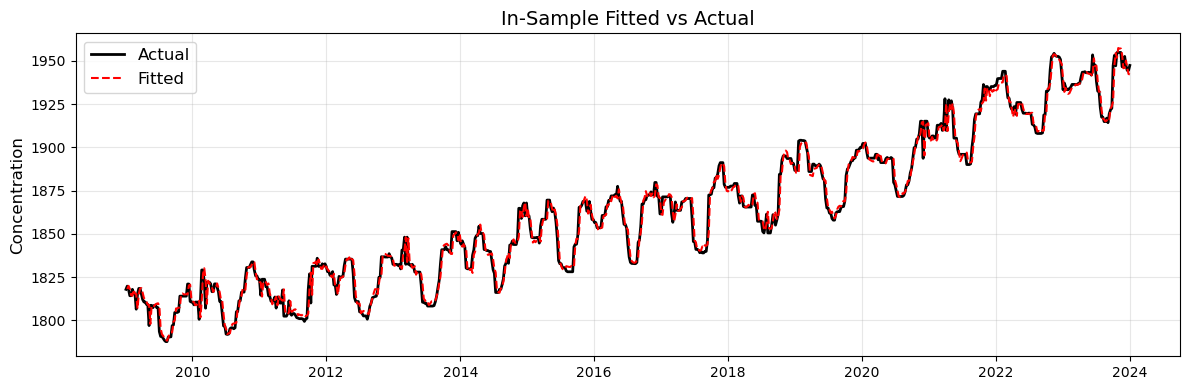

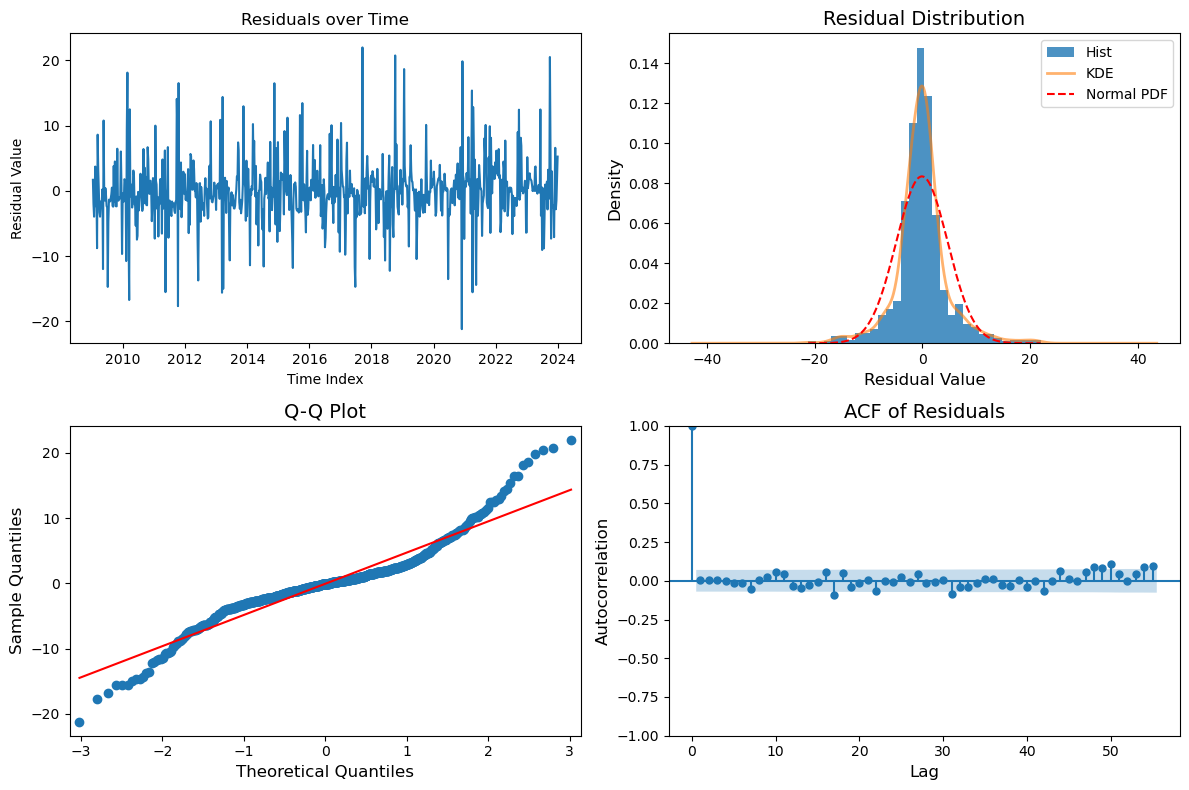


=== Residual Diagnostic Tests ===

--- Distribution Diagnostics ---
Jarque-Bera test:
	JB = 541.43
	p = 0.0000
	Skewness = 0.348
	kurtosis = 7.016

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.8688
	lag 4: p = 0.9992
	lag 13: p = 0.7389
	lag 26: p = 0.4574
	lag 52: p = 0.0287

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0002***
	Lag 26: p-value = 0.0011***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.8079
White: p = 0.8729


In [84]:
SARIMA711000 = in_sample_resid_analysis(
    train_recent15,
    order=(7,1,1),
    seasonal_order=(1,0,0,52),
    trim_first=True,
    run_hetero=True
)

**Interpretation of in-sample residual analysis**

- Adding one seasonal order (AR, P=1) improved moderately improved the distribution and autocorrelation, though the residuals remain non-normally distributed.  
- Adding non-seasonal orders (AR, P=7) substantially improved the distribution and autocorrelation, though some seasonal structure remains (lag 52 p-value < 0.05). Likely need to model with an exogenous variable.  
- None of the added orders removed the volatility.  Need GARCH. 

# Fourier seasonal regressors as exogenous variable

In [89]:
def make_fourier_terms(index, period=52, K=3):
    '''
    index  : pd.DatetimeIndex (weekly)
    period : int (e.g. 52 weeks)
    K      : number of harmonic pairs (1..K)
    returns: DataFrame of shape (len(index), 2*K) with sin_k and cos_k columns
    '''
    # integer time t (0,1,2,...) aligned with index
    t = np.arange(len(index))
    fourier = {}
    for k in range(1, K+1):
        fourier[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier, index=index)

In [90]:
# function to evaluate K choices (uses the evaluate_models_tscv which accepts exog)

def select_best_K(models_list, data, exog_index, K_candidates=[1,2,3], n_splits=5):
    results = []
    for K in K_candidates:
        exog_k = make_fourier_terms(exog_index, period=52, K=K)
        df_res = evaluate_models_tscv(
            models_list=models_list,
            data=data,
            exog=exog_k,
            n_splits=n_splits
        )
        # choose best by RMSE_mean (ensure non-empty)
        if not df_res.empty:
            best_row = df_res.sort_values('RMSE_mean').iloc[0]
            results.append({'K': K,
                            'best_order': best_row['order'],
                            'best_seasonal': best_row['seasonal_order'],
                            'RMSE_mean': best_row['RMSE_mean'],
                            'AIC_mean': best_row['AIC_mean']})
        else:
            results.append({'K': K, 'best_order': None, 'best_seasonal': None, 'RMSE_mean': np.nan, 'AIC_mean': np.nan})
    return pd.DataFrame(results)

In [91]:
# choose a candidate non-seasonal model list (example: p=0..3, q=0..2)

models_list = []
for p in range(0,8):
    for q in range(0,3):
        models_list.append({'order': (p,1,q), 'seasonal_order': (0,0,0,0)})

# run selection over K=1..3 on train_recent15
K_choices = [1,2,3]
k_results = select_best_K(models_list, train_recent15, train_recent15.index, K_candidates=K_choices)
print(k_results.sort_values('RMSE_mean'))

Evaluating 24 models with 5 folds each
Total iterations: 120

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models:   0%|          | 0/24 [00:00<?, ?it/s]

Model (0, 1, 0), (0, 0, 0, 0) failed on fold 2: name 'forecast_volatility' is not defined
Model (0, 1, 0), (0, 0, 0, 0) failed on fold 3: name 'forecast_volatility' is not defined
Model (0, 1, 0), (0, 0, 0, 0) failed on fold 4: name 'forecast_volatility' is not defined


Models:   0%|          | 0/24 [00:00<?, ?it/s]

Model (0, 1, 0), (0, 0, 0, 0) failed on fold 5: name 'forecast_volatility' is not defined
Model (0, 1, 0), (0, 0, 0, 0) failed on fold 6: name 'forecast_volatility' is not defined


NameError: name 'forecast_volatility' is not defined

# Model volatility with GARCH

                                     SARIMAX Results                                      
Dep. Variable:                   CH4_preprocessed   No. Observations:                 1722
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -5092.859
Date:                            Tue, 04 Nov 2025   AIC                          10201.717
Time:                                    11:54:45   BIC                          10245.322
Sample:                                01-06-1991   HQIC                         10217.850
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.007      0.512      0.609      -0.011       0.018
ar.L1          0.0361      0.943   

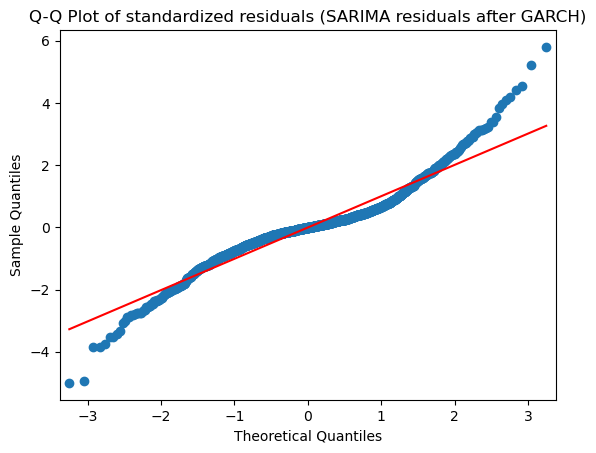

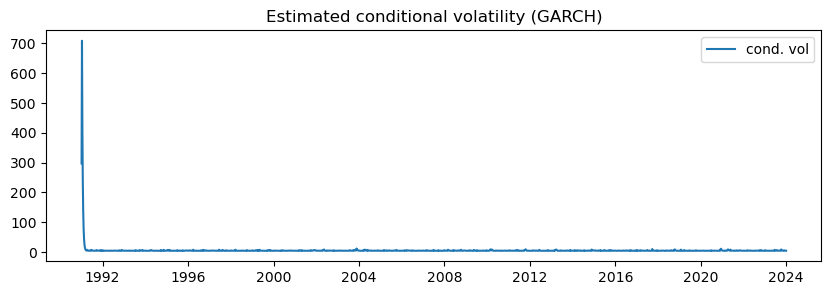

In [191]:
# 1) Fit SARIMA (mean)
sarima_order = (3,1,1)
seasonal_order = (1,0,1,52)
mean_model = SARIMAX(train_preprocessed, order=sarima_order, seasonal_order=seasonal_order,
                     enforce_stationarity=True, enforce_invertibility=True, trend='c')
mean_res = mean_model.fit(disp=False, method='powell')   # use method you found more stable
residuals = mean_res.resid.dropna()

# quick check
print(mean_res.summary())

# 2) Fit GARCH(1,1) on the residuals (zero mean)
# Use dist='t' if you expect heavy tails; start with normal
garch = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
garch_res = garch.fit(disp='off')
print(garch_res.summary())

# 3) Diagnostics on standardized residuals
std_resid = garch_res.std_resid  # standardized residuals

# ACF/Ljung-Box on standardized residuals
lb_std = acorr_ljungbox(std_resid.dropna(), lags=[1,5,10,52], return_df=True)
print("\nLjung-Box (standardized residuals):")
print(lb_std[['lb_stat','lb_pvalue']])

# Ljung-Box / ARCH on squared standardized residuals
lb_sq = acorr_ljungbox(std_resid.dropna()**2, lags=[1,5,10,52], return_df=True)
print("\nLjung-Box (squared standardized residuals):")
print(lb_sq[['lb_stat','lb_pvalue']])

# Q-Q plot
qqplot(std_resid.dropna(), line='s')
plt.title('Q-Q Plot of standardized residuals (SARIMA residuals after GARCH)')
plt.show()

# time series plot of conditional variance
plt.figure(figsize=(10,3))
plt.plot(garch_res.conditional_volatility, label='cond. vol')
plt.title('Estimated conditional volatility (GARCH)')
plt.legend()
plt.show()

In [192]:
garch_t = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
garch_t_res = garch_t.fit(disp='off')
print(garch_t_res.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -4867.92
Distribution:      Standardized Student's t   AIC:                           9743.85
Method:                  Maximum Likelihood   BIC:                           9765.65
                                              No. Observations:                 1722
Date:                      Tue, Nov 04 2025   Df Residuals:                     1722
Time:                              12:09:52   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

# Fourier seasonal regressors as exogenous variable

In [264]:
def make_fourier_terms(index, period=52, K=3):
    '''
    index  : pd.DatetimeIndex (weekly)
    period : int (e.g. 52 weeks)
    K      : number of harmonic pairs (1..K)
    returns: DataFrame of shape (len(index), 2*K) with sin_k and cos_k columns
    '''
    # integer time t (0,1,2,...) aligned with index
    t = np.arange(len(index))
    fourier = {}
    for k in range(1, K+1):
        fourier[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier, index=index)

In [271]:
period = 52
K = 3 
exog = make_fourier_terms(train_recent15.index, period=period, K=K)

exog_train15 = exog.loc[train_recent15.index]
# exog_test = make_fourier_terms(test_preprocessed.index, period=period, K=K)

print('exog_train15 shape == train_recent15 shape:', exog_train15.shape[0] == train_recent15.shape[0])
# print('exog_test shape == test_preprocessed shape:', exog_test.shape[0] == test_preprocessed.shape[0])

exog_train15 shape == train_recent15 shape: True


## TimeSeriesSplit CV on ARIMAX models

In [267]:
# Focus the model search on the d=1, ACF/PACF patterns and exogenous Fourier terms

def get_models_with_exog():
    '''Generate models based on ACF/PACF patterns for d=1 with exogenous variables'''
    models = []
    
    for p in range(0, 8):
        for q in range(0, 3):
            models.append({
                'order': (p, 1, q),
                'seasonal_order': (0,0,0,0)
            })
    return models

models_exog = get_models_with_exog()
print(f'Generated {len(models_exog)} models for evaluation\n')

models_df = pd.DataFrame(models_exog)
print(models_df)

Generated 24 models for evaluation

        order seasonal_order
0   (0, 1, 0)   (0, 0, 0, 0)
1   (0, 1, 1)   (0, 0, 0, 0)
2   (0, 1, 2)   (0, 0, 0, 0)
3   (1, 1, 0)   (0, 0, 0, 0)
4   (1, 1, 1)   (0, 0, 0, 0)
5   (1, 1, 2)   (0, 0, 0, 0)
6   (2, 1, 0)   (0, 0, 0, 0)
7   (2, 1, 1)   (0, 0, 0, 0)
8   (2, 1, 2)   (0, 0, 0, 0)
9   (3, 1, 0)   (0, 0, 0, 0)
10  (3, 1, 1)   (0, 0, 0, 0)
11  (3, 1, 2)   (0, 0, 0, 0)
12  (4, 1, 0)   (0, 0, 0, 0)
13  (4, 1, 1)   (0, 0, 0, 0)
14  (4, 1, 2)   (0, 0, 0, 0)
15  (5, 1, 0)   (0, 0, 0, 0)
16  (5, 1, 1)   (0, 0, 0, 0)
17  (5, 1, 2)   (0, 0, 0, 0)
18  (6, 1, 0)   (0, 0, 0, 0)
19  (6, 1, 1)   (0, 0, 0, 0)
20  (6, 1, 2)   (0, 0, 0, 0)
21  (7, 1, 0)   (0, 0, 0, 0)
22  (7, 1, 1)   (0, 0, 0, 0)
23  (7, 1, 2)   (0, 0, 0, 0)


In [272]:
# Run the TimeSerisSplit CV evaluation

ARIMAexog_models = evaluate_models_tscv(
    models_list=models_exog,
    data=train_recent15,
    exog=exog_train15,
    n_splits=5
)

sorted_models_exog_df = ARIMAexog_models.sort_values(by='RMSE_mean')
print('Candidate models with exogenous variable for train set sorted by RMSE mean')
print(sorted_models_exog_df)

Evaluating 24 models with 5 folds each
Total iterations: 120

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models:  67%|██████▋   | 16/24 [00:32<00:24,  3.08s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (5, 1, 1), (0, 0, 0, 0) did not converge on fold 2


Models: 100%|██████████| 24/24 [01:08<00:00,  2.84s/it]


Total duration: 1.14 minutes
Average duration per model: 0.05 minutes

Number of models successfully evaluated: 24
Candidate models with exogenous variable for train set sorted by RMSE mean
        order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
0   (0, 1, 0)   (0, 0, 0, 0)                 5               1.0  16.249967   
3   (1, 1, 0)   (0, 0, 0, 0)                 5               1.0  17.041654   
22  (7, 1, 1)   (0, 0, 0, 0)                 5               1.0  17.084351   
23  (7, 1, 2)   (0, 0, 0, 0)                 5               1.0  17.116673   
19  (6, 1, 1)   (0, 0, 0, 0)                 5               1.0  17.216600   
20  (6, 1, 2)   (0, 0, 0, 0)                 5               1.0  17.284088   
4   (1, 1, 1)   (0, 0, 0, 0)                 5               1.0  17.364445   
1   (0, 1, 1)   (0, 0, 0, 0)                 5               1.0  17.376838   
6   (2, 1, 0)   (0, 0, 0, 0)                 5               1.0  17.442405   
17  (5, 1, 2)   (0,

Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.443
MAE:  3.079
MAPE: 0.17%
R2:   0.989


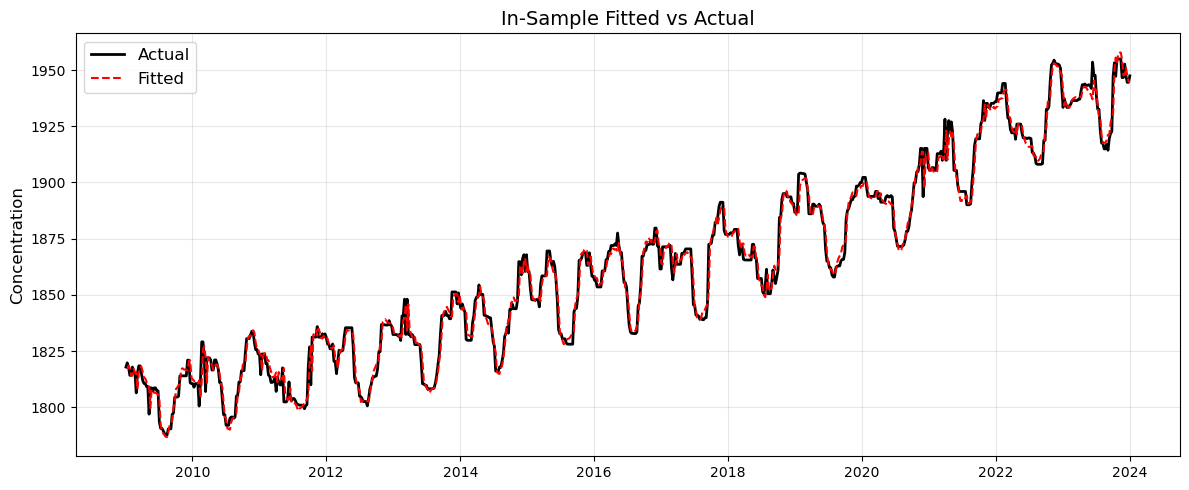

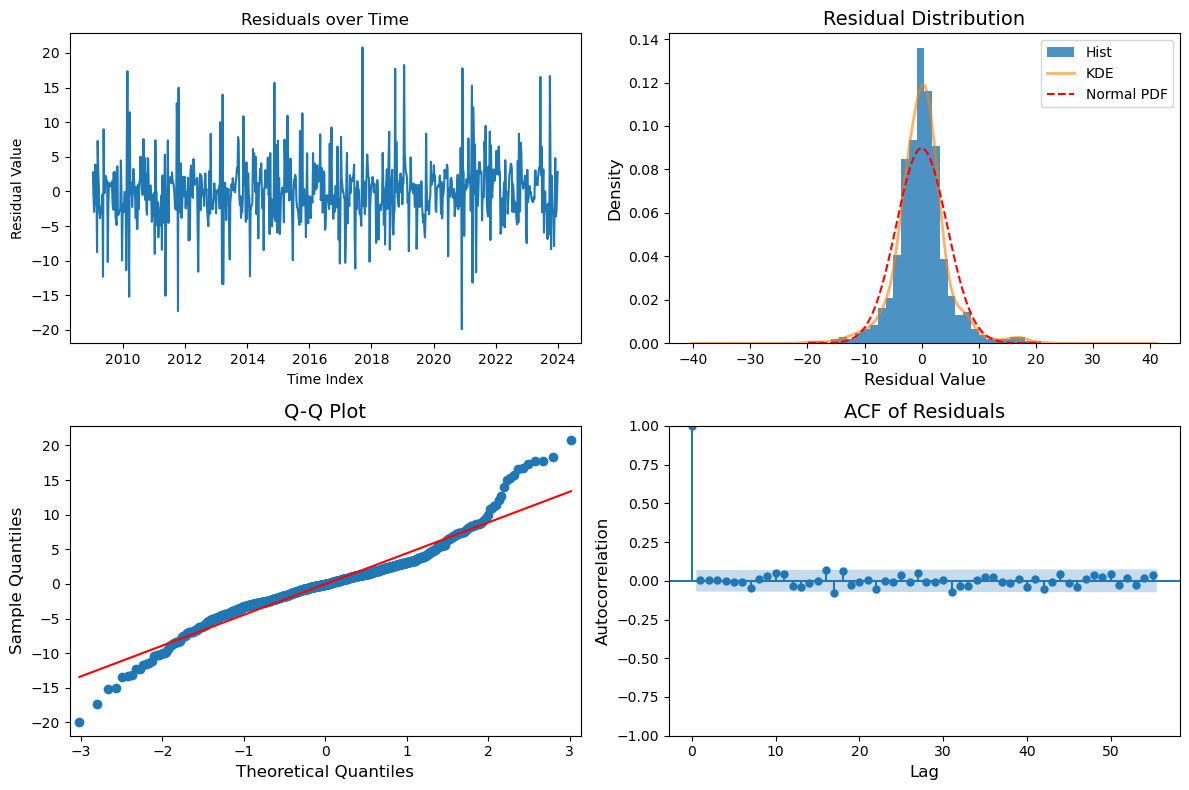


--- Residual Diagnostic Tests ---
Durbin-Watson statistic: 1.987
	<2: positive autocorrelation 
	~= 2: no autocorrelation 
	>2: negative autocorrelation

Jarque-Bera test:
	JB = 424.93
	p = 0.0000
	Skewness = 0.338
	kurtosis = 6.547

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.8655
	lag 5: p = 0.9994
	lag 10: p = 0.9059
	lag 52: p = 0.7099

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0000***
	Lag 26: p-value = 0.0002***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.8866
White: p = 0.7863


In [318]:
# run in-sample residual analysis on the non-log ARIMAX model

ARIMA010000 = in_sample_resid_analysis(
    train_recent15,
    order=(7,1,0),
    seasonal_order=(0,0,0,0),
    exog=exog_train15,
    trim_first=True,
    run_hetero=True
)

## Compare SARIMA and ARIMAX with Fourier terms

In [319]:
# function to evaluate K choices (uses the evaluate_models_tscv which accepts exog)
def select_best_K(models_list, data, exog_index, K_candidates=[1,2,3], n_splits=5):
    results = []
    for K in K_candidates:
        exog_k = make_fourier_terms(exog_index, period=52, K=K)
        df_res = evaluate_models_tscv(
            models_list=models_list,
            data=data,
            exog=exog_k,
            n_splits=n_splits
        )
        # choose best by RMSE_mean (ensure non-empty)
        if not df_res.empty:
            best_row = df_res.sort_values('RMSE_mean').iloc[0]
            results.append({'K': K,
                            'best_order': best_row['order'],
                            'best_seasonal': best_row['seasonal_order'],
                            'RMSE_mean': best_row['RMSE_mean'],
                            'AIC_mean': best_row['AIC_mean']})
        else:
            results.append({'K': K, 'best_order': None, 'best_seasonal': None, 'RMSE_mean': np.nan, 'AIC_mean': np.nan})
    return pd.DataFrame(results)

In [321]:
# choose a candidate non-seasonal model list (example: p=0..3, q=0..2)
models_list = []
for p in range(0,8):
    for q in range(0,3):
        models_list.append({'order': (p,1,q), 'seasonal_order': (0,0,0,0)})

# run selection over K=1..3 on train_recent15
K_choices = [1,2,3]
k_results = select_best_K(models_list, train_recent15, train_recent15.index, K_candidates=K_choices)
print(k_results.sort_values('RMSE_mean'))

Evaluating 24 models with 5 folds each
Total iterations: 120

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models: 100%|██████████| 24/24 [00:41<00:00,  1.72s/it]



Total duration: 0.69 minutes
Average duration per model: 0.03 minutes

Number of models successfully evaluated: 24
Evaluating 24 models with 5 folds each
Total iterations: 120

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models: 100%|██████████| 24/24 [00:54<00:00,  2.26s/it]



Total duration: 0.90 minutes
Average duration per model: 0.04 minutes

Number of models successfully evaluated: 24
Evaluating 24 models with 5 folds each
Total iterations: 120

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models:  67%|██████▋   | 16/24 [00:31<00:24,  3.04s/it]C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model (5, 1, 1), (0, 0, 0, 0) did not converge on fold 2


Models: 100%|██████████| 24/24 [01:07<00:00,  2.81s/it]


Total duration: 1.12 minutes
Average duration per model: 0.05 minutes

Number of models successfully evaluated: 24
   K best_order best_seasonal  RMSE_mean     AIC_mean
0  1  (5, 1, 0)  (0, 0, 0, 0)  12.452080  3702.733165
1  2  (0, 1, 0)  (0, 0, 0, 0)  15.244019  3640.487080
2  3  (0, 1, 0)  (0, 0, 0, 0)  16.249967  3641.452660


**Interpretation of results**
- K=1 gives the best cross-validated RMSE of 12.45 and, therefore best captures the dominant seasonal cycle.  

In [325]:
# pick best_K, get exog and run a final CV for a small model set and compare to SARIMA

best_K = int(k_results.sort_values('RMSE_mean').iloc[0]['K'])
exog_best = make_fourier_terms(train_recent15.index, period=52, K=best_K)

# small set of nonseasonal candidates to compare
candidate_models = [
    {'order': (0,1,0), 'seasonal_order': (0,0,0,0)},
    {'order': (1,1,0), 'seasonal_order': (0,0,0,0)},
    {'order': (1,1,1), 'seasonal_order': (0,0,0,0)},
    {'order': (5,1,0), 'seasonal_order': (0,0,0,0)},
    {'order': (7,1,0), 'seasonal_order': (0,0,0,0)}
]

res_arimax = evaluate_models_tscv(candidate_models, train_recent15, exog=exog_best, n_splits=5)
print('ARIMAX-with-Fourier results:')
print(res_arimax.sort_values('RMSE_mean').head())

# Compare to a few SARIMA seasonal models (example)
sarima_candidates = [
    {'order': (0,1,0), 'seasonal_order': (1,0,0,52)},
    {'order': (0,1,0), 'seasonal_order': (1,1,0,52)},
    {'order': (1,1,1), 'seasonal_order': (1,0,0,52)},
    {'order': (1,1,1), 'seasonal_order': (1,1,0,52)},
    {'order': (2,1,1), 'seasonal_order': (1,0,0,52)},
    {'order': (5,1,0), 'seasonal_order': (1,0,0,52)},
    {'order': (5,1,0), 'seasonal_order': (1,1,0,52)},
    {'order': (7,1,0), 'seasonal_order': (1,0,0,52)},
    {'order': (7,1,0), 'seasonal_order': (1,1,0,52)}
]
res_sarima = evaluate_models_tscv(sarima_candidates, train_recent15, exog=None, n_splits=5)
print('SARIMA seasonal results:')
print(res_sarima.sort_values('RMSE_mean').head())

Evaluating 5 models with 5 folds each
Total iterations: 25

Fold 1: Train=510 (9.8 years), Val=52 (1.0 years), Total=562
Fold 2: Train=562 (10.8 years), Val=52 (1.0 years), Total=614
Fold 3: Train=614 (11.8 years), Val=52 (1.0 years), Total=666
Fold 4: Train=666 (12.8 years), Val=52 (1.0 years), Total=718
Fold 5: Train=718 (13.8 years), Val=52 (1.0 years), Total=770



Models: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



Total duration: 0.05 minutes
Average duration per model: 0.01 minutes

Number of models successfully evaluated: 5
ARIMAX-with-Fourier results:
       order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
3  (5, 1, 0)   (0, 0, 0, 0)                 5               1.0  12.452080   
0  (0, 1, 0)   (0, 0, 0, 0)                 5               1.0  12.749692   
2  (1, 1, 1)   (0, 0, 0, 0)                 5               1.0  12.785850   
1  (1, 1, 0)   (0, 0, 0, 0)                 5               1.0  12.795087   
4  (7, 1, 0)   (0, 0, 0, 0)                 5               1.0  13.232899   

   RMSE_std   MAE_mean     AIC_mean     BIC_mean  Seasonal_Strength  \
3  4.230022  10.259390  3702.733165  3738.021800           9.336901   
0  4.608769  10.564295  3697.152744  3710.385982           9.479342   
2  4.632028  10.593481  3699.390304  3721.445701           9.473034   
1  4.639111  10.617928  3698.026700  3715.671017           9.478951   
4  4.769744  11.010828  3695.501

Models: 100%|██████████| 9/9 [08:41<00:00, 58.00s/it]


Total duration: 8.70 minutes
Average duration per model: 0.97 minutes

Number of models successfully evaluated: 9
SARIMA seasonal results:
       order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
5  (5, 1, 0)  (1, 0, 0, 52)                 5               1.0  16.372291   
7  (7, 1, 0)  (1, 0, 0, 52)                 5               1.0  16.884521   
0  (0, 1, 0)  (1, 0, 0, 52)                 5               1.0  17.121105   
4  (2, 1, 1)  (1, 0, 0, 52)                 5               1.0  17.295328   
2  (1, 1, 1)  (1, 0, 0, 52)                 5               1.0  19.942317   

   RMSE_std   MAE_mean     AIC_mean     BIC_mean  Seasonal_Strength  \
5  3.806103  13.171914  3715.438684  3746.316239           1.576027   
7  4.269553  13.661651  3711.460692  3751.160406           1.580489   
0  4.223675  14.061727  3711.953130  3720.775289           1.835658   
4  4.011449  14.170303  3713.646131  3735.701528           2.311395   
2  4.828047  16.434057  3706.627904 

**Interpretation of comparison between ARIMAX (Fourier terms) and SARIMA models**
- ARIMAX
  - All models have similar metrics with (5,1,0) and (0,1,0) being the top two models.  The simplest model (0,1,0) has the second lowest RMSE, second lowest AIC, and lowest BIC scores.  So it is a top contender based on metrics and simplicity.
  - The Fourier term, with K=1, explains the seaonal pattern well, without seasonal AR and MA terms.
  - Even the simplest model, ARIMAX(0,1,0)+Fourier(K=1) yiels residuals that are basically white noise based on Ljung-Box p-values.
  - ARIMAX models converge in 0.6 seconds on average.

- SARIMA
  - RMSE values for all models are significantly higher (~ 16-20) compared to the ARIMAX models (~ 12.5-13)
  - SARIMA models are much slower compared to the ARIMAX models (~ 60 seconds/model vs ~ 0.6 seconds/model).

Note: First residual removed before plotting and diagnostics.


--- In-Sample Accuracy ---
RMSE: 4.589
MAE:  3.106
MAPE: 0.17%
R2:   0.989


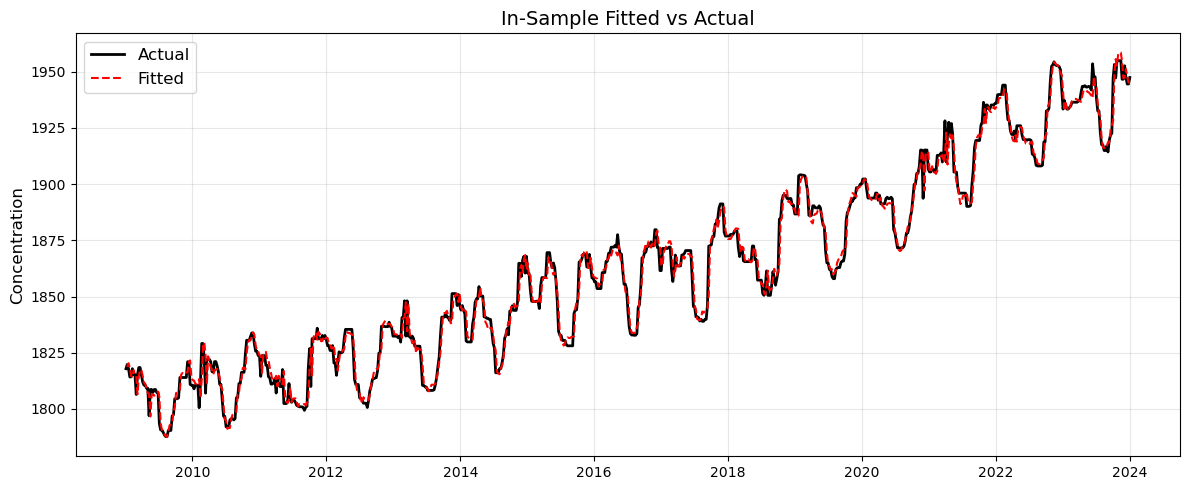

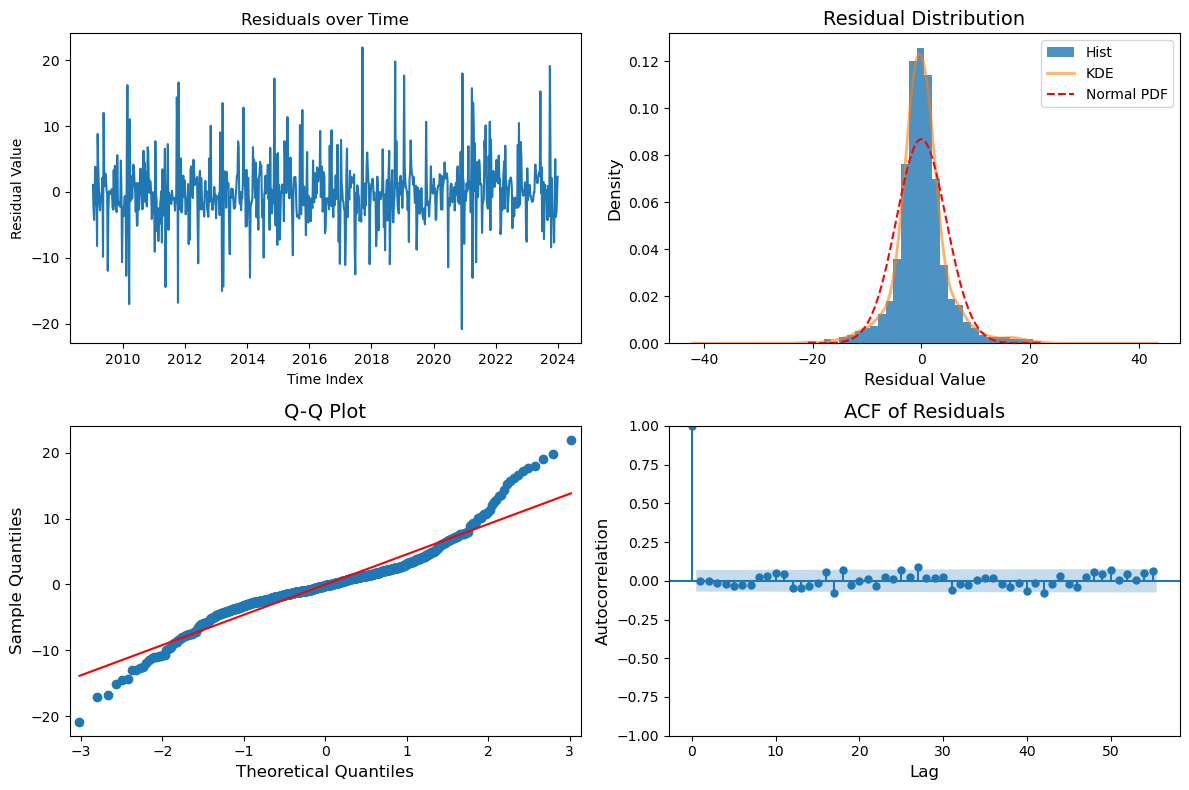


--- Residual Diagnostic Tests ---
Durbin-Watson statistic: 1.998
	< 2: positive autocorrelation 
	~= 2: no autocorrelation 
	> 2: negative autocorrelation

Jarque-Bera test:
	JB = 518.81
	p = 0.0000
	Skewness = 0.410
	kurtosis = 6.905

--- Autocorrelation Diagnostics ---
Ljung-Box Test:
(H0: No autocorrelation up to specified lags)
	lag 1: p = 0.9839
	lag 5: p = 0.9149
	lag 10: p = 0.8034
	lag 52: p = 0.0993

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
(H0: No ARCH effects (constant variance))
	Lag 1: p-value = 0.0000***
	Lag 4: p-value = 0.0000***
	Lag 8: p-value = 0.0000***
	Lag 12: p-value = 0.0002***
	Lag 26: p-value = 0.0036***

--- Heteroscedasticity Tests ---
Breusch-Pagan: p = 0.8259
White: p = 0.8987


In [362]:
# run in sample residual analytics on the ARIMAX model

best_K = 1
exog_best = make_fourier_terms(train_recent15.index, period=52, K=best_K)
ARIMAX010ft = in_sample_resid_analysis(
    train=train_recent15, 
    order=(7,1,1), 
    seasonal_order=(0,0,0,0), 
    exog=exog_best,
    trim_first=True,
    run_hetero=True)

In [38]:
RMSE_low = 0.009505
RMSE_high = 0.011436
RMSE_std_low = 0.000950
RMSE_std_high = 0.001346

print('=== Model Performance Analysis ===')

# basic RMSE comparison
rmse_range_pct = ((RMSE_high - RMSE_low) / RMSE_low) * 100
print(f'RMSE range: {RMSE_low:.6f} to {RMSE_high:.6f}')
print(f'Best model has {rmse_range_pct:.1f}% lower error than the worst model')

# model stability across folds (cv = coefficient of variation)
cv_best = (RMSE_std_low / RMSE_low) * 100
cv_worst = (RMSE_std_high / RMSE_high) * 100
print(f'\nModel stability (CV = coefficient of variation, lower = more consistent):')
print(f'Best model CV across folds: {cv_best:.1f}%')
print(f'Worst model CV across folds: {cv_worst:.1f}%')

=== Model Performance Analysis ===
RMSE range: 0.009505 to 0.011436
Best model has 20.3% lower error than the worst model

Model stability (CV = coefficient of variation, lower = more consistent):
Best model CV across folds: 10.0%
Worst model CV across folds: 11.8%


I have sorted the model performances based on RMSE, which is the standard deviation of the residuals (prediction errors train vs validation sets)

The model with the lowest mean RMSE has ~20% lower error compared to the model with the highest mean RMSE, which is a moderate difference that may be meaningul. However, the narrow range of error (0.010205 to 0.011192) suggests that all models are performing reasonably well on the 5 fold cross validation sets.  

The RMSE_std reports on the consistency/stability of model performance across different time periods (folds).  Models with a coefficient of variation < 10% are considered to have good stability (>15% may be problematic).  So, even the worst model has reasonably good stability across multiple validation sets.  

Note: seasonal_strength measures how much seasonal variation that the forecast captures.  The magnitude of the values relate to the strength of the seasonal pattern (higher value means greater seasonal pattern).  There is good consistency in the seasonal_strength score across all models indicating that all do a reasonably good jop at detecting seasonal patterns.  But, the low Ljung-Box p values (0 << 0.05) for all models indicate remaining seasonal structure in the residuals.  

The low Ljung-Box mean p values suggest that the seasonal orders (P,Q) may need to be increased to capture more/all of the seasonal patterns.  

In [39]:
# Apply the Pareto Frontier Approach to determine the best model on both RMSE and complexity (BIC)
# BIC is used since it penalizes complexity more so than AIC. 

def select_pareto_optimal_models(results_df, complexity_metric='BIC_mean'):
    '''Find models that are optimal in the RMSE-complexity trade-off'''
    # calculate parameter count as complexity measure
    results_df['param_count'] = (
        results_df['order'].apply(lambda x: x[0] + x[2]) + # p,q
        results_df['seasonal_order'].apply(lambda x: x[0] + x[2]) # P,Q
                                 )
    # find Pareto frontier: models where no other model is better in both RMSE and complexity
    pareto_optimal = []

    for _, candidate in results_df.iterrows():
        dominated = False
        for _, other in results_df.iterrows():
            # check if other model is bettter in both dimensions
            if (other['RMSE_mean'] <= candidate['RMSE_mean'] and
                other[complexity_metric] <= candidate[complexity_metric] and
                (other['RMSE_mean'] < candidate['RMSE_mean'] or 
                 other[complexity_metric] < candidate[complexity_metric])):
                dominated = True
                break
        if not dominated:
            pareto_optimal.append(candidate)

    return pd.DataFrame(pareto_optimal).sort_values('RMSE_mean')

# get Pareto-optimal models
pareto_models = select_pareto_optimal_models(candidate_model_results_df)
print('Pareto-optimal models (RMSE vs BIC):')
print(pareto_models[['order', 'seasonal_order', 'RMSE_mean', 'BIC_mean', 'param_count']])

Pareto-optimal models (RMSE vs BIC):
        order seasonal_order  RMSE_mean      BIC_mean  param_count
3   (4, 1, 0)  (1, 1, 1, 52)   0.009505 -11566.234030            6
4   (5, 1, 0)  (1, 1, 1, 52)   0.009520 -11589.413522            7
6   (7, 1, 0)  (1, 1, 1, 52)   0.009536 -11611.865417            9
15  (1, 1, 1)  (0, 1, 1, 52)   0.010010 -11762.959105            3
8   (2, 1, 1)  (1, 1, 1, 52)   0.010236 -11770.658901            5


# Validate Model Finalists on the Test Set

In [40]:
# extract order and seasonal_order from the Pareto frontier results
final_candidates = [
    {'order': row['order'], 'seasonal_order': row['seasonal_order']}
    for _, row in pareto_models.iterrows()
]

def validate_on_test_set(models_list, train_data, test_data, test_data_original):
    '''Validation of final candidate models on the originally held out test set'''

    validation_test_results = []

    for model_params in models_list:
        model = SARIMAX(train_data,
                        order=model_params['order'],
                        seasonal_order=model_params['seasonal_order'])

        results = model.fit(method='powell', disp=False)

        # forecast on the test set
        forecast = results.get_forecast(steps=len(test_data))
        forecast_values = forecast.predicted_mean

        # calculate metrics
        rmse_test = np.sqrt(mean_squared_error(test_data, forecast_values))
        mae_test = mean_absolute_error(test_data, forecast_values)

        # convert final forecasts to original units for interpretation
        forecast_original = np.exp(forecast_values)

        validation_test_results.append({
            'order': model_params['order'],
            'seasonal_order': model_params['seasonal_order'],
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'rmse_test_original': np.sqrt(mean_squared_error(test_data_original, forecast_original)),
            'mae_test_original': mean_absolute_error(test_data_original, forecast_original)
        })

    validation_test_results_df = pd.DataFrame(validation_test_results)
    return validation_test_results_df.sort_values(by='rmse_test')

start_time = time.perf_counter()

test_performance = validate_on_test_set(final_candidates,
                                        CH4_train_log_preprocessed,
                                        CH4_test_log_preprocessed,
                                        CH4_test_preprocessed)

end_time = time.perf_counter()
elapsed_time = end_time - start_time

print('Evaluation metrics for final candidate models')
print('-' * 45)
print(f'Elapsed time: {elapsed_time/60:.2f} minutes\n')
print(test_performance)

Evaluation metrics for final candidate models
---------------------------------------------
Elapsed time: 28.47 minutes

       order seasonal_order  rmse_test  mae_test  rmse_test_original  \
2  (7, 1, 0)  (1, 1, 1, 52)   0.004636  0.003592            8.983181   
1  (5, 1, 0)  (1, 1, 1, 52)   0.004860  0.003523            9.411591   
3  (1, 1, 1)  (0, 1, 1, 52)   0.005097  0.003489            9.868525   
4  (2, 1, 1)  (1, 1, 1, 52)   0.005098  0.003474            9.870663   
0  (4, 1, 0)  (1, 1, 1, 52)   0.005108  0.003570            9.891836   

   mae_test_original  
2           6.971737  
1           6.836281  
3           6.768671  
4           6.739167  
0           6.927335  


In [42]:
# I will compare the top Pareto frontier model, which is also the most complex, with the most simple model
# and the lowest peforming model since it was the highest performing model on the train set.

CH4_test_mean = CH4_test_preprocessed.mean()
print(f'CH4_test mean: {CH4_test_mean:.2f} ppb')
print(f'The (7,1,0)(1,1,1,52) model error is {(8.983181/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (1,1,1)(0,1,1,52) model error is {(9.868525/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (4,1,0)(0,1,1,52) model error is {(9.891836/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')

CH4_test mean: 1943.87 ppb
The (7,1,0)(1,1,1,52) model error is 0.46% of the mean CH4 test data
The (1,1,1)(0,1,1,52) model error is 0.51% of the mean CH4 test data
The (4,1,0)(0,1,1,52) model error is 0.51% of the mean CH4 test data


**Interpretation of candidate model results**

error relative to test set data mean:
  - (7,1,0)(1,1,1,52) - 0.46%
  - (1,1,1)(0,1,1,52) - 0.51%
  - (4,1,0)(1,1,1,52) - 0.51%

All three models should be considered for the next round of evaluation.  The most complex model has 7 non-seasonal AR terms, which is consisted with the differecing analysis ACF/PACF plots.  The simplest model is minimally lesser by only 0.05% RMSE and may generalize better for forecasting.  The (4,1,0)(1,1,1,52) model has similar performance to the other two models based on RMSE, performed the best on the in-sample fit, and represents the middle ground of complexity.  

# Evaluate best model in-sample residuals

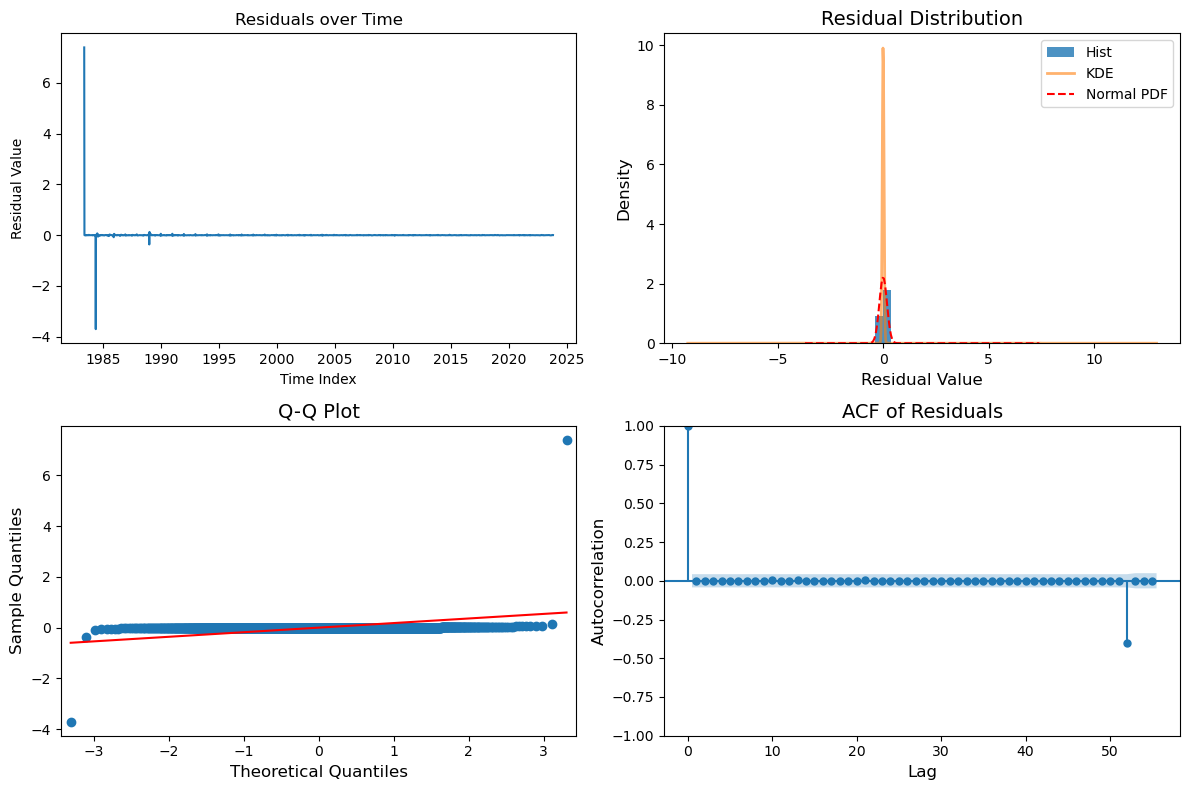


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9634
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0371, White p = 0.0035


In [60]:
# Evaluate SARIMA(7,1,0)(1,1,1,52)

sarima710111 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(7,1,0),
    seasonal_order=(1,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

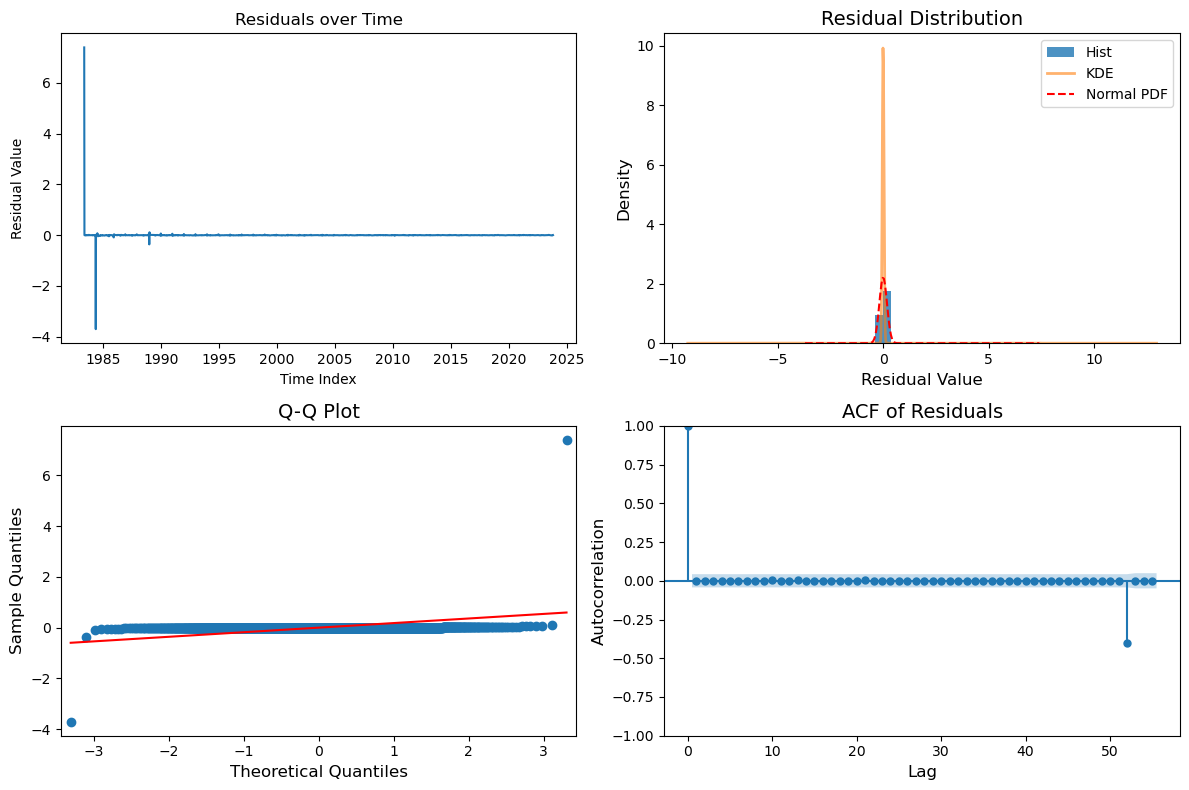


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9651
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0371, White p = 0.0035


In [61]:
# Evaluate SARIMA(1,1,1)(0,1,1,52)

sarima111011 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(0,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

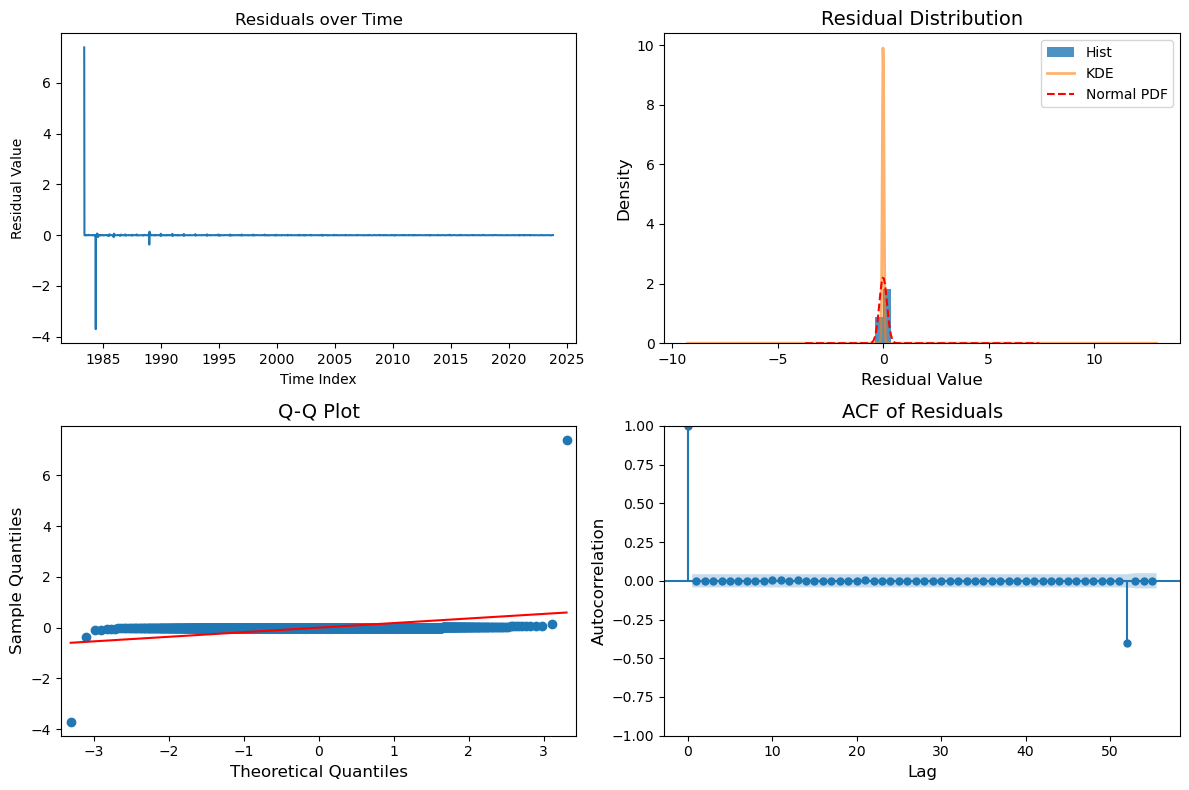


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9635
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0370, White p = 0.0035


In [62]:
# Evaluate SARIMA(4,1,0)(1,1,1,52)

sarima410111 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(4,1,0),
    seasonal_order=(1,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

**Interpretation of in-sample residual analyses**

all models show approximately the same results, which is likely due to the extreme values seen as spikes in the residuals plot pre-1990s.  These extreme values distort variance, skewness, and kurtosis.
- residuals plot - significant residual value "spikes" seen pre-1990.
- residual distribution - residuals are leptokurtic 
- Q-Q plot - signficant tails on left and right, though seem more right-skewed.
- ACF plot - all lags up to 52 are insignificant.  The significant spike at lag 52 suggests remaining seasonal structure.
- Ljung-Box test for autocorrelation - no signicant autocorrelation at specified lags except for lag 52, as seen in the correlogram.
- ARCH test - no volatility clustering at specified lags.  i.e. there is no statistically significant evidence that the squared residuals up to the specified lags (1, 5, 10, or 52 weeks ago) influence the current period's variance.  Importantly, the lack of evidence for time-dependent volatility clustering means that I likely won't need an ARCH/GARCH model.  
- Breusch-Pagan and White tests - p-values < 0.05 for both tests suggesting the variance of all model's errors is not constant - the residuals show general heteroscedasticity.

# Evaluate best model out-of-sample residuals (predictions vs test set)

=== Out-of-Sample Residual Analysis: SARIMA(7,1,0)(1,1,1,52) ===
Residual mean: -0.00001, std: 0.00467
Skew: -1.022, Kurtosis: 0.159
Shapiro-Wilk normality test: p-value = 0.0000

--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


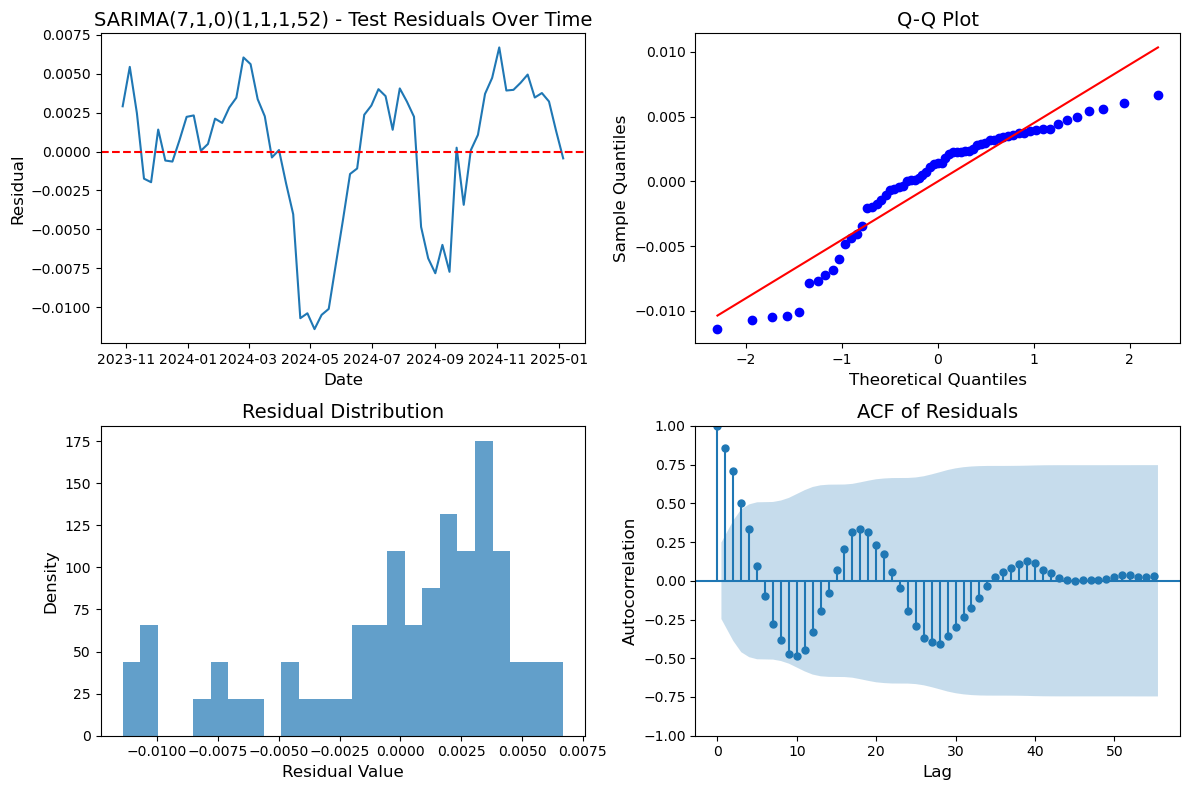

In [68]:
# Evaluate SARIMA(7,1,0)(1,1,1,52) out-of-sample residuals (prediction vs test set)

sarima710111_outsample_resid, sarima710111_outsample_results = out_of_sample_resid_analysis(
    train_data=CH4_train_log_preprocessed,
    test_data=CH4_test_log_preprocessed,
    order=(7,1,0),
    seasonal_order=(1,1,1,52),
    model_name='SARIMA(7,1,0)(1,1,1,52)'
)

=== Out-of-Sample Residual Analysis: SARIMA(1,1,1)(0,1,1,52) ===
Residual mean: -0.00216, std: 0.00459
Skew: -1.054, Kurtosis: 0.226
Shapiro-Wilk normality test: p-value = 0.0000

--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


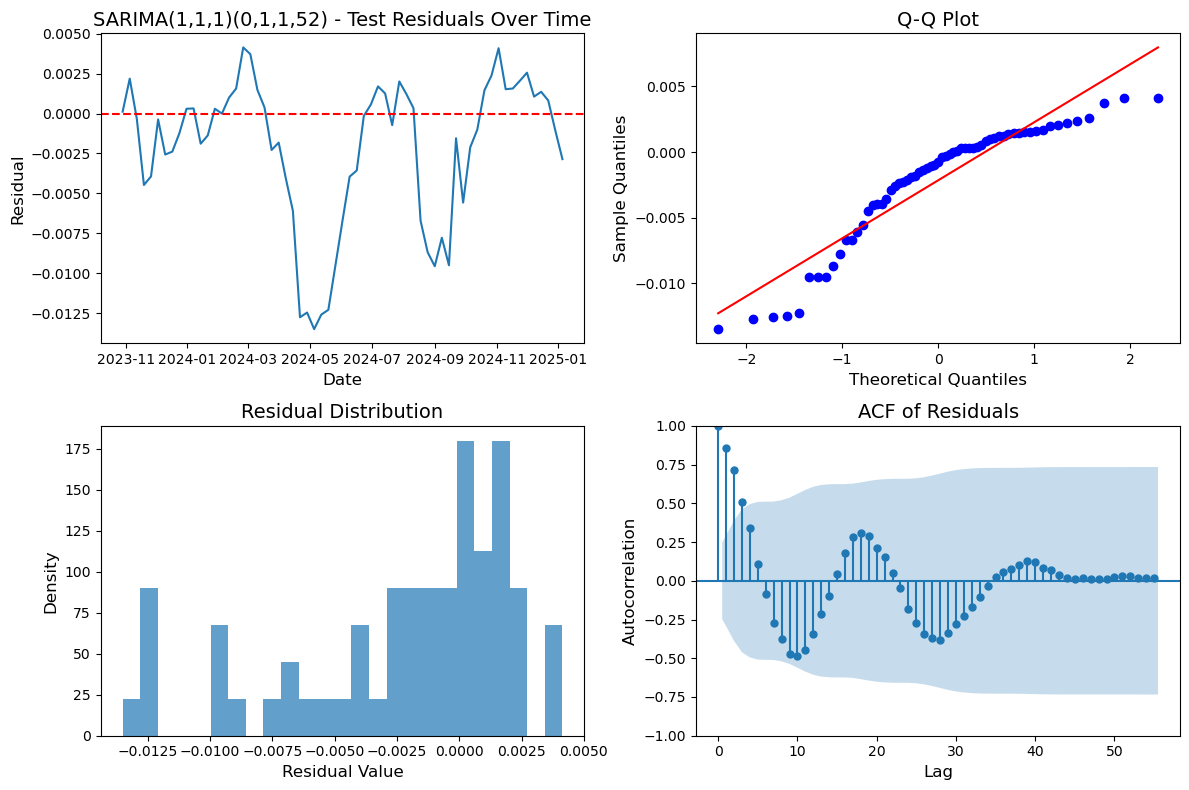

In [69]:
# Evaluate SARIMA(1,1,1)(0,1,1,52) out-of-sample residuals (prediction vs test set)

sarima111011_outsample_resid, sarima111011_outsample_results = out_of_sample_resid_analysis(
    train_data=CH4_train_log_preprocessed,
    test_data=CH4_test_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(0,1,1,52),
    model_name='SARIMA(1,1,1)(0,1,1,52)'
)

I will try a dummy regressor for the SARIMAX model to handle the significant spikes seen in the pre-1990 residuals.  A dummy regressor is a specific type of exogenous X variable that takes on either 1 (spike) or 0 (no spike) at all timepoints.  So, instead of letting the SARIMA model's AR or MA try to model the extreme outlier(s) or ending up in the error term, the dummy variable captures the magnitude of the unique event (shock).  

Top outlier dates: [Timestamp('1983-05-08 00:00:00'), Timestamp('1984-05-06 00:00:00'), Timestamp('1988-12-18 00:00:00'), Timestamp('1988-12-25 00:00:00'), Timestamp('1985-11-24 00:00:00')]

Top 5 residuals:
            |Residual|  Residual (Signed)
Date                                     
1983-05-08    7.400811           7.400811
1984-05-06    3.702927          -3.702927
1988-12-18    0.365038          -0.365038
1988-12-25    0.128283           0.128283
1985-11-24    0.080956          -0.080956


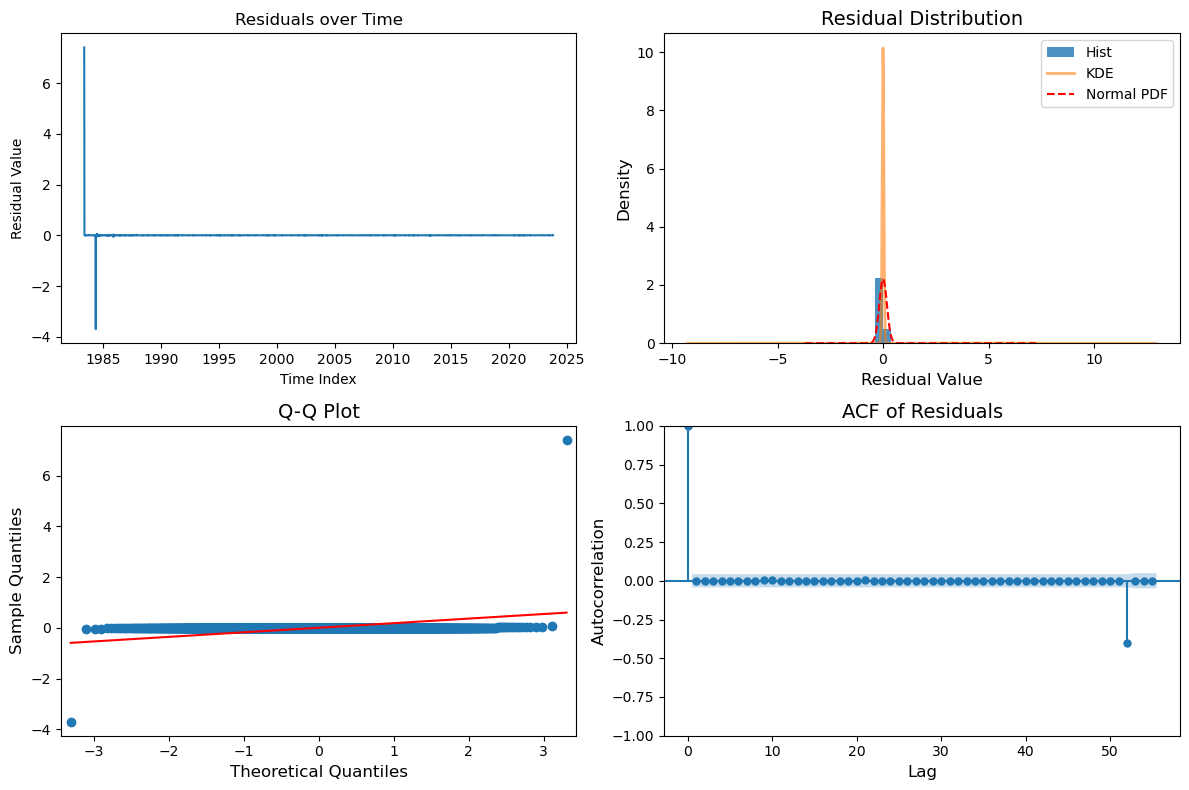


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9728
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000


In [136]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.api import qqplot

def make_outlier_exog(index, outlier_dates):
    exog = pd.DataFrame(0, index=index, columns=[f'out_{i}' for i in range(len(outlier_dates))])
    for i, dt in enumerate(outlier_dates):
        if dt in index:
            exog.loc[dt, f'out_{i}'] = 1
        else:
            # if exact date not present (possible weekly freq), find nearest match
            nearest = index.get_indexer([dt], method='nearest')[0]
            exog.iloc[nearest, i] = 1
    return exog

initial = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c').fit(method='powell', disp=False)
init_resid = initial.resid.abs()
top_dates = init_resid.nlargest(5).index.tolist()
print(f'Top outlier dates: {top_dates}')

# create individual dummies, exogenous regressors, for the "outliers"
exog_train_indiv = make_outlier_exog(CH4_train_log_preprocessed.index, top_dates)

# the following code is the in_sample_resid_ansalysis function from model_evaluation.py, with included exog parameter
model = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                exog=exog_train_indiv,
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c')
results = model.fit(method='powell', disp=False)
residuals = results.resid

top_resid_df = init_resid.nlargest(5).to_frame(name='|Residual|')
top_resid_df.index.name = 'Date'

# show both signed and absolute values
signed_resid = initial.resid.loc[top_resid_df.index]
top_resid_df['Residual (Signed)'] = signed_resid

print('\nTop 5 residuals:')
print(top_resid_df)

# --- Plot residual diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
# Residual time series
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals over Time')
axes[0,0].set_xlabel('Time Index')
axes[0,0].set_ylabel('Residual Value')

# Histogram + KDE
axes[0,1].hist(residuals, bins=30, density=True, alpha=0.8, label='Hist')
residuals.plot(kind='kde', ax=axes[0,1], linewidth=2, alpha=0.6, label='KDE')

# Theoretical normal curve
x_vals = np.linspace(residuals.min(), residuals.max(), 200)
normal_pdf = stats.norm.pdf(x_vals, loc=residuals.mean(), scale=residuals.std())
axes[0,1].plot(x_vals, normal_pdf, color='r', linestyle='--', label='Normal PDF')
axes[0,1].set_title('Residual Distribution', fontsize=14)
axes[0,1].set_xlabel('Residual Value', fontsize=12)
axes[0,1].set_ylabel('Density', fontsize=12)
axes[0,1].legend()

# Q-Q plot
qqplot(residuals, line='s', ax=axes[1,0])
axes[1,0].set_title('Q-Q Plot', fontsize=14)
axes[1,0].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[1,0].set_ylabel('Sample Quantiles', fontsize=12)

# ACF plot
plot_acf(residuals, lags=55, ax=axes[1,1])
axes[1,1].set_title('ACF of Residuals', fontsize=14)
axes[1,1].set_xlabel('Lag', fontsize=12)
axes[1,1].set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

# Ljung-Box test
lb = acorr_ljungbox(residuals, lags=[1,5,10,52], return_df=True)
print('\n--- Autocorrelation Diagnostics ---')
print('Ljung-Box Test')
print('H0: No autocorrelation up to specified lags')
for lag in [1,5,10,52]:
    print(f"lag {lag}: p = {lb.loc[lag, 'lb_pvalue']:.4f}")

In [130]:
# Two major spikes remain.  I will check the top 5 residuals again to verify that they are the same two
# early spikes seen prior to the SARIMAX model fit with exogenous dummy variables.  

print('Top 5 Residuals for Magnitude, Before and After Dummy Variables')
print('\nBefore dummy variables:')
print(init_resid.abs().nlargest(5))
print('\nAfter dummy variables:')
print(residuals.abs().nlargest(5))

Top 5 Residuals for Magnitude, Before and After Dummy Variables

Before dummy variables:
date
1983-05-08    7.400811
1984-05-06    3.702927
1988-12-18    0.365038
1988-12-25    0.128283
1985-11-24    0.080956
dtype: float64

After dummy variables:
date
1983-05-08    7.404007
1984-05-06    3.698867
1985-11-17    0.061678
1984-06-10    0.053787
1984-07-08    0.044161
dtype: float64


In [86]:
# Verify that all outlier dates exist in the train set index

for dt in top_dates:
    print(dt, dt in CH4_train_log_preprocessed.index)

1983-05-08 00:00:00 True
1984-05-06 00:00:00 True
1988-12-18 00:00:00 True
1988-12-25 00:00:00 True
1985-11-24 00:00:00 True


All outlier dates do exist in the train set and the dummy variables can be properly aligned to the exact observations in the train set.

In [87]:
# Verify that the exogenous variable matrix is correct

print(exog_train_indiv.sum())               # each column should sum to 1
print(exog_train_indiv.loc[top_dates])

out_0    1
out_1    1
out_2    1
out_3    1
out_4    1
dtype: int64
            out_0  out_1  out_2  out_3  out_4
date                                         
1983-05-08      1      0      0      0      0
1984-05-06      0      1      0      0      0
1988-12-18      0      0      1      0      0
1988-12-25      0      0      0      1      0
1985-11-24      0      0      0      0      1


The exogenous matrix is correct.  Each dummy column corresponds to the correct specific date.

In [121]:
# After fit `results`

# extract coefficients and standard errors for outlier dummy regressors
outlier_cols = [c for c in results.params.index if 'out' in c or 'outlier' in c]

# create a summary DataFrame
outlier_summary = pd.DataFrame({
    'Top Dates': top_dates,
    'Coefficient': results.params[outlier_cols],
    'Std. Error': results.bse[outlier_cols]  # standard errors of parameter estimates
})

# compute z-scores and two sided p-values
outlier_summary['z-score'] = outlier_summary['Coefficient'] / outlier_summary['Std. Error']
outlier_summary['p-value'] = 2 * (1 - stats.norm.cdf(np.abs(outlier_summary['z-score'])))

# pretty print
print('\nOutlier Regressor Coefficients Summary:')
print(outlier_summary.round(5).to_string())                 


Outlier Regressor Coefficients Summary:
       Top Dates  Coefficient  Std. Error   z-score  p-value
out_0 1983-05-08     -0.00320     0.00260  -1.22814  0.21940
out_1 1984-05-06     -0.00566     0.00225  -2.50942  0.01209
out_2 1988-12-18     -0.36281     0.01168 -31.06242  0.00000
out_3 1988-12-25     -0.00028     0.01183  -0.02378  0.98103
out_4 1985-11-24     -0.07240     0.00078 -93.38812  0.00000


The dummy variables captured two substantial residual shocks: 1988-12-18 (out_2) and 1985-11-24 (out_4)

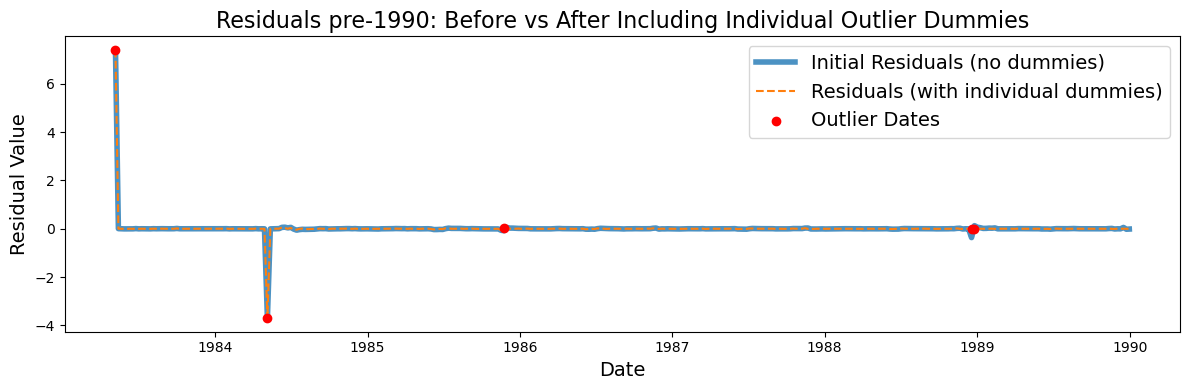

In [148]:
# Compare residuals before vs after including individual outlier dummies
plt.figure(figsize=(12, 4))
plt.plot(initial.resid.loc[:'1989'], label='Initial Residuals (no dummies)', linewidth=4, alpha=0.8)
plt.plot(results.resid.loc[:'1989'], label='Residuals (with individual dummies)', linestyle='--',alpha=1)

# Mark the top residual dates in red
plt.scatter(top_dates, results.resid.loc[top_dates], color='red', zorder=5, label='Outlier Dates')

plt.legend(fontsize=14)
plt.title('Residuals pre-1990: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

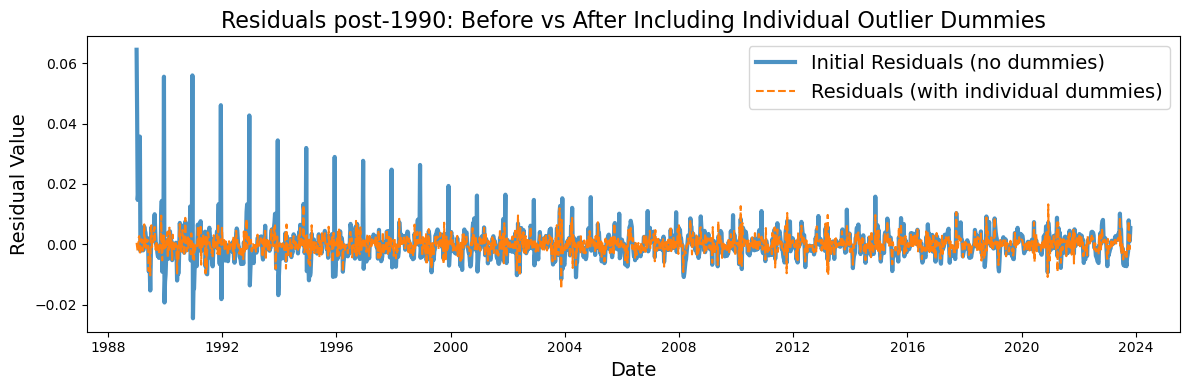

In [147]:
# Compare residuals before vs after including individual outlier dummies
plt.figure(figsize=(12, 4))
plt.plot(initial.resid.loc['1989':], label='Initial Residuals (no dummies)', linewidth=3, alpha=0.8)
plt.plot(results.resid.loc['1989':], label='Residuals (with individual dummies)', linestyle='--',alpha=1)

# Mark the top residual dates in red
# plt.scatter(top_dates, results.resid.loc[top_dates], color='red', zorder=5, label='Outlier Dates')

plt.legend(fontsize=14)
plt.title('Residuals post-1990: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

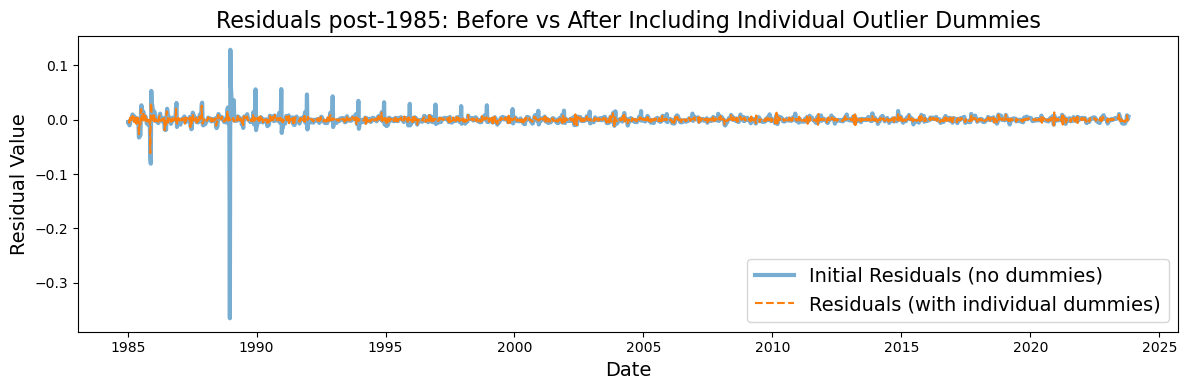

In [146]:
plt.figure(figsize=(12,4))
plt.plot(initial.resid.loc['1985':], label='Initial Residuals (no dummies)', linewidth=3, alpha=0.6)
plt.plot(results.resid.loc['1985':], label='Residuals (with individual dummies)', linestyle='--', alpha=1)

plt.legend(loc='lower right', fontsize=14)
plt.title('Residuals post-1985: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

Top outlier dates: [Timestamp('1983-05-08 00:00:00'), Timestamp('1984-05-06 00:00:00'), Timestamp('1988-12-18 00:00:00'), Timestamp('1988-12-25 00:00:00'), Timestamp('1985-11-24 00:00:00')]

Top 5 residuals:
            |Residual|  Residual (Signed)
Date                                     
1983-05-08    7.400811           7.400811
1984-05-06    3.702927          -3.702927
1988-12-18    0.365038          -0.365038
1988-12-25    0.128283           0.128283
1985-11-24    0.080956          -0.080956


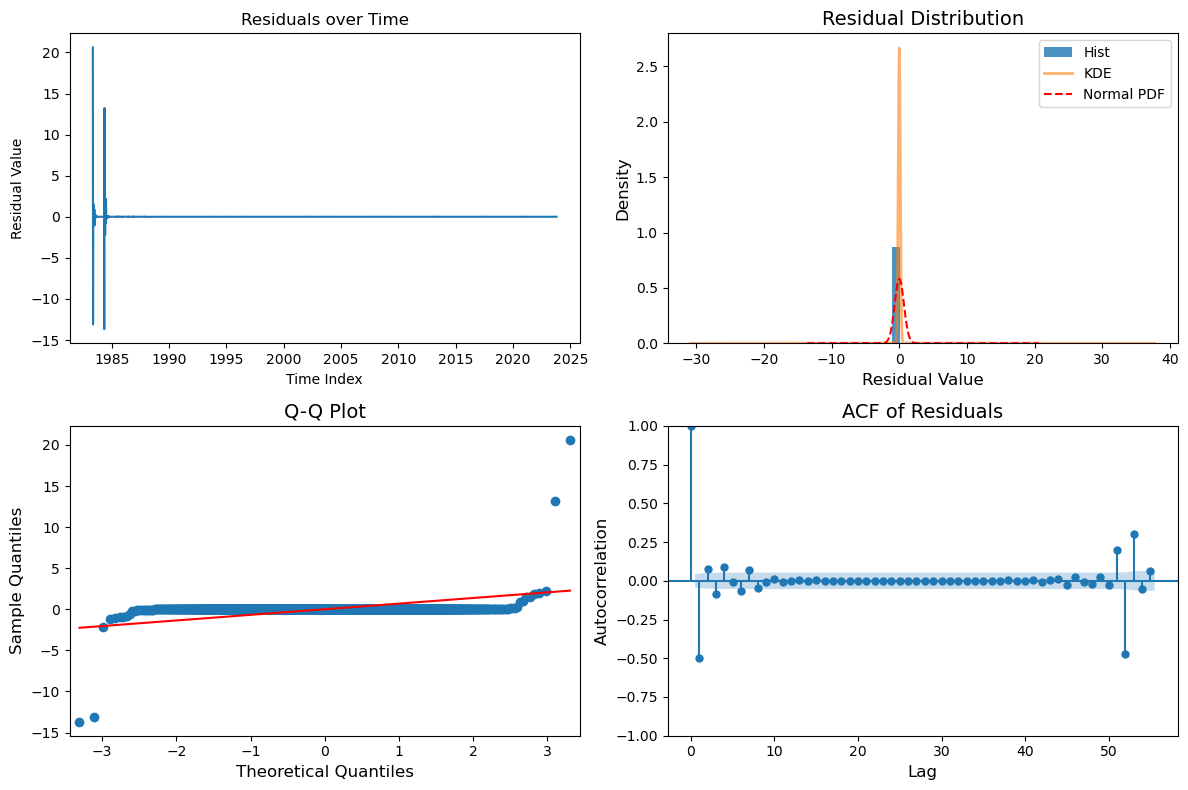


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000


In [135]:
def make_outlier_exog(index, outlier_dates):
    exog = pd.DataFrame(0, index=index, columns=[f'out_{i}' for i in range(len(outlier_dates))])
    for i, dt in enumerate(outlier_dates):
        if dt in index:
            exog.loc[dt, f'out_{i}'] = 1
        else:
            # if exact date not present (possible weekly freq), find nearest match
            nearest = index.get_indexer([dt], method='nearest')[0]
            exog.iloc[nearest, i] = 1
    return exog

initial = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c').fit(method='powell', disp=False)
init_resid = initial.resid.abs()
top_dates = init_resid.nlargest(5).index.tolist()
print(f'Top outlier dates: {top_dates}')

# create grouped dummy (one column) OR individual dummies
# grouped:
# exog_train_grouped = pd.DataFrame({'outlier_flag': 0}, index=train.index)
# exog_train_grouped.loc[top_dates, 'outlier_flag'] = 1

# create individual dummies
exog_train_indiv = make_outlier_exog(CH4_train_log_preprocessed.index, top_dates)

model = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                exog=exog_train_indiv,
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c',
                initialization='diffuse')
results = model.fit(method='powell', disp=False)
residuals = results.resid

top_resid_df = init_resid.nlargest(5).to_frame(name='|Residual|')
top_resid_df.index.name = 'Date'

# show both signed and absolute values
signed_resid = initial.resid.loc[top_resid_df.index]
top_resid_df['Residual (Signed)'] = signed_resid

print('\nTop 5 residuals:')
print(top_resid_df)

# --- Plot residual diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
# Residual time series
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals over Time')
axes[0,0].set_xlabel('Time Index')
axes[0,0].set_ylabel('Residual Value')

# Histogram + KDE
axes[0,1].hist(residuals, bins=30, density=True, alpha=0.8, label='Hist')
residuals.plot(kind='kde', ax=axes[0,1], linewidth=2, alpha=0.6, label='KDE')

# Theoretical normal curve
x_vals = np.linspace(residuals.min(), residuals.max(), 200)
normal_pdf = stats.norm.pdf(x_vals, loc=residuals.mean(), scale=residuals.std())
axes[0,1].plot(x_vals, normal_pdf, color='r', linestyle='--', label='Normal PDF')
axes[0,1].set_title('Residual Distribution', fontsize=14)
axes[0,1].set_xlabel('Residual Value', fontsize=12)
axes[0,1].set_ylabel('Density', fontsize=12)
axes[0,1].legend()

# Q-Q plot
qqplot(residuals, line='s', ax=axes[1,0])
axes[1,0].set_title('Q-Q Plot', fontsize=14)
axes[1,0].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[1,0].set_ylabel('Sample Quantiles', fontsize=12)

# ACF plot
plot_acf(residuals, lags=55, ax=axes[1,1])
axes[1,1].set_title('ACF of Residuals', fontsize=14)
axes[1,1].set_xlabel('Lag', fontsize=12)
axes[1,1].set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

# Ljung-Box test
lb = acorr_ljungbox(residuals, lags=[1,5,10,52], return_df=True)
print('\n--- Autocorrelation Diagnostics ---')
print('Ljung-Box Test')
print('H0: No autocorrelation up to specified lags')
for lag in [1,5,10,52]:
    print(f"lag {lag}: p = {lb.loc[lag, 'lb_pvalue']:.4f}")

# Save Best Model Parameters for Production

In [123]:
import json
from datetime import datetime

model_config_best = {
    'model_type': 'SARIMAX',
    'order': (7,1,0),
    'seasonal_order': (1,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010205,
        'MAE_mean': 0.007906
    },
    'test_performance': {  # From final validation
        'RMSE_log': 0.004636,
        'MAE_log': 0.003592,
        'RMSE_original': 8.983181,
        'MAE_original': 6.971737
    },
    'selection_rationale': 'Best overall RMSE in both CV and test validation',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

model_config_best_simple = {
    'model_type': 'SARIMAX',
    'order': (1,1,1),
    'seasonal_order': (0,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010530,
        'MAE_mean': 0.008095
    },
    'test_performance': {
        'RMSE_log': 0.005097,
        'MAE_log': 0.003489,
        'RMSE_original': 9.868525,
        'MAE_original': 6.768671
    },
    'selection_rationale': 'Pareto-optimal balance of simplicity and performance',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config_best, f, indent=2)

with open('../results/CH4_train_best_simple_model_config.json', 'w') as f:
    json.dump(model_config_best_simple, f, indent=2)

print('CH4 best model configuration saved.  Re-fit in next notebook.')
print('CH4 best simple model configuration saved.  Re-fit in next notebook.')

CH4 best model configuration saved.  Re-fit in next notebook.
CH4 best simple model configuration saved.  Re-fit in next notebook.


**NOTE** 
- Check deepseek regarding saving the models for the entire dataset, not just the train set
- may want to produce the plots and analyze residuals of prediction vs test set in this notebook and treat the next notebook as just forecasting.  